# Sequence generator Oct 7

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import utils
class Sequence(torch.utils.data.Dataset):
    def __init__(self, K, D,  
                 len_context = 1,
                len_data = 60000):

        # if K < 40000:
        self.len_context = len_context
        self.D = D
    
        # x = rng.standard_normal((K, D)) * (1.0 / np.sqrt(D)) # shape: (K, D) 
        true_betas = torch.randn((K, D)) * (10.0 / np.sqrt(D)) # shape: (K, D)
        self.true_betas = true_betas
        self.K = K 
        self.D = D
        self.len_data = len_data
        
    def __len__(self):
        return self.len_data

    def __getitem__(self, task: int):
        task_ind = torch.randint(0, self.K, (1,)).item()
        beta_incontext = self.true_betas[task_ind].unsqueeze(1) # shape: (D, 1)
        x = torch.randn((self.len_context, self.D)) * (1.0 / np.sqrt(self.D)) # shape: (self.len_context, D) 
        noise = torch.randn((self.len_context, 1)) * args.sigma_xi
        y = torch.matmul(x, beta_incontext) + noise

        # concat x and y 
        samples = torch.cat([x, y], axis = 1) # shape: (self.len_context, D+1)
        ytest = samples[-1, -1].clone() 
        samples[-1, -1] = 0.0 # remove ytest from samples 
        # print (ytest, samples[-1, -1])
        # print ((samples[:, :-1] @ beta_incontext + noise).flatten(), samples[:, -1].flatten())
        # w
        
          
        return samples.type(torch.float32), ytest.type(torch.float32), beta_incontext.type(torch.float32)  
dataset = Sequence(K = 1000, D = 1, len_context = 100, len_data = 100)

tensor([[3.0715]])


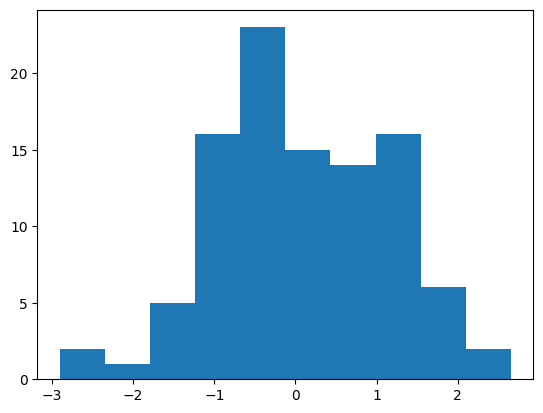

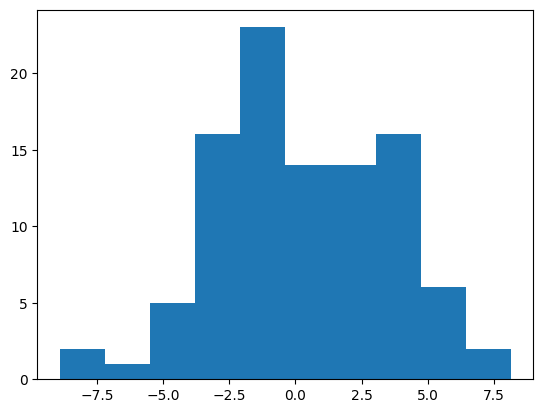

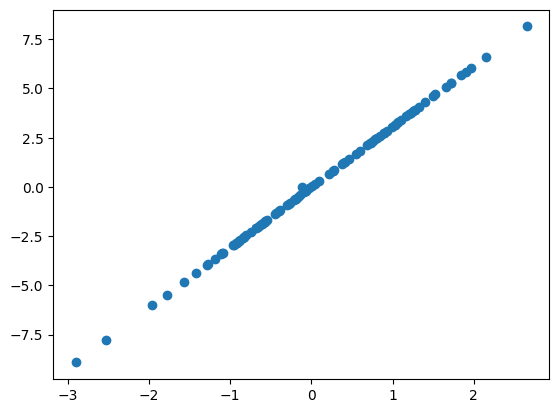

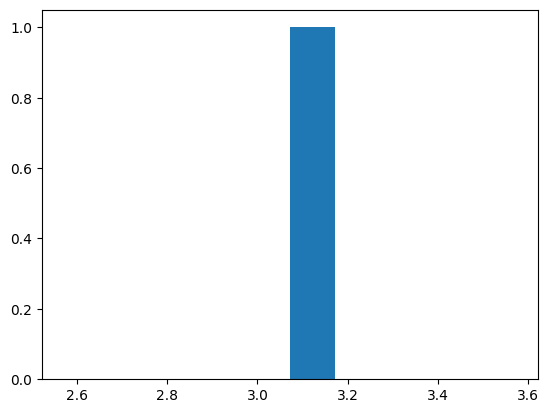

In [5]:
args = utils.dotdict()
args.sigma_xi=0.0
x, y, beta = dataset[1]
print (beta)
plt.hist (x[:, :-1].numpy().flatten(), bins=10)
plt.show()
plt.hist (x[:-1, -1].numpy().flatten(),bins=10)
plt.show()
plt.scatter (x[:, 0].numpy().flatten(), x[:, -1].numpy().flatten())
plt.show()
plt.hist (beta.numpy())
plt.show()

# Oct 7: Prelim results (1 layer transformer, isotropic beta & x, 1000 features, N=[10,50,100], Adam, no noise)

In [34]:
from glob import glob
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict
import numpy as np
sns.set(context='talk', font_scale=1.0,font = "Arial",color_codes=True, palette='deep', style='ticks', rc={'mathtext.fontset': 'cm', 'xtick.direction': 'in','ytick.direction': 'in', 'axes.linewidth': 1.5, 'figure.dpi':70, 'text.usetex':True, 'font.size':24})
 
fnames = glob(f"./cache/linreg_oct5_specgen_transformer1layer_K_100000*")

cmap = plt.get_cmap('tab10')(range(10))
 
dx,dy = 8,8
Ns, D_visible_fracs = [], []
train_losses = []
icl_indistribution_losses, icl_outdistribution_losses = [], []
iwl_indistribution_losses, iwl_outdistribution_losses = [], []
train_losses_vs_time, icl_indistribution_losses_vs_time, icl_outdistribution_losses_vs_time = [], [], []
time = []
Ns_time = []
for run_i, fname in enumerate(fnames):
     
    try:
        with open(fname, 'rb') as f:
            r = pickle.load(f)
            N = str(r["args"]["len_context"]) 
            D_visible_frac = r["args"]["D_visible_frac"]
    except Exception as e:
        print(e)
        continue
    idx_fun = lambda x: x 
    f = idx_fun
    train_loss = f(r["logs"][-1]["train_loss"])
    icl_indistribution_loss = f(r["logs"][-1]["icl_indistribution_loss"])
    icl_outdistribution_loss = f(r["logs"][-1]["icl_outdistribution_loss"])
    iwl_indistribution_loss = f(r["logs"][-1]["iwl_indistribution_loss"])
    iwl_outdistribution_loss = f(r["logs"][-1]["iwl_outdistribution_loss"])
    train_losses.append(train_loss)
    icl_indistribution_losses.append(icl_indistribution_loss)
    icl_outdistribution_losses.append(icl_outdistribution_loss)
    iwl_indistribution_losses.append(iwl_indistribution_loss)
    iwl_outdistribution_losses.append(iwl_outdistribution_loss)
    if D_visible_frac==0.9:
        icl_indistribution_losses_vs_time.extend([f(i["icl_indistribution_loss"]) for i in r["logs"]])
        icl_outdistribution_losses_vs_time.extend([f(i["icl_outdistribution_loss"]) for i in r["logs"]])
        train_losses_vs_time.extend([f(i["train_loss"]) for i in r["logs"]])
        Ns_time.extend([N]*len(r["logs"]))
        time.extend([i["epoch"] for i in r["logs"]])
    Ns.append(N)
    D_visible_fracs.append(D_visible_frac)



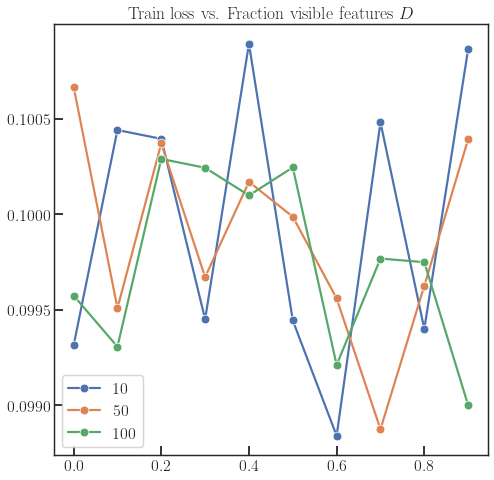

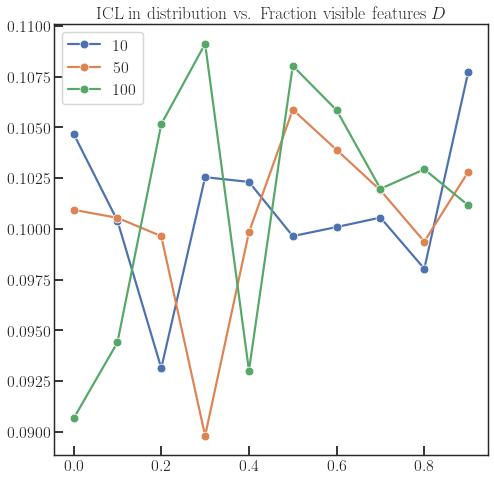

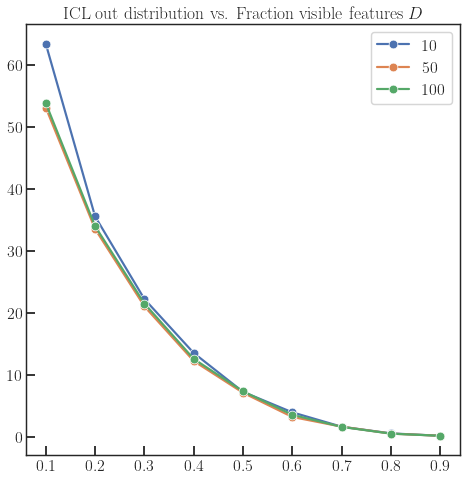

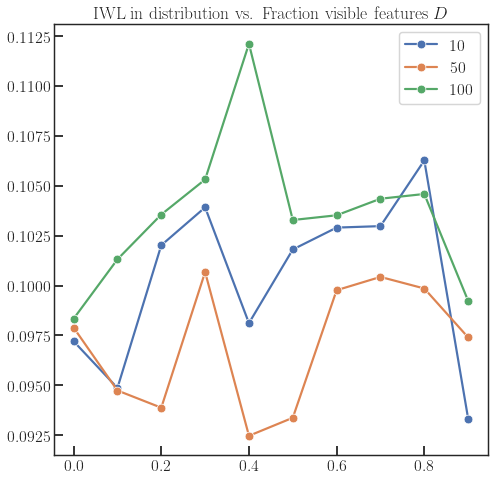

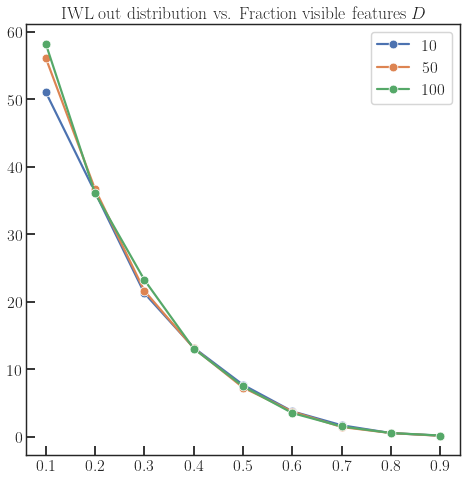

600 600


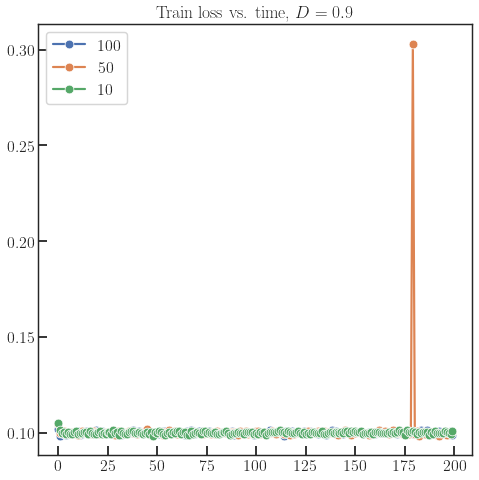

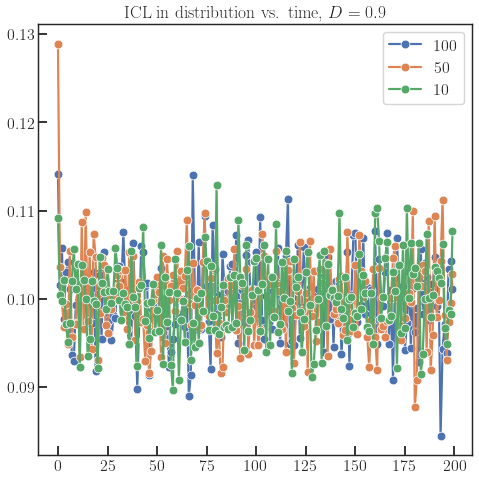

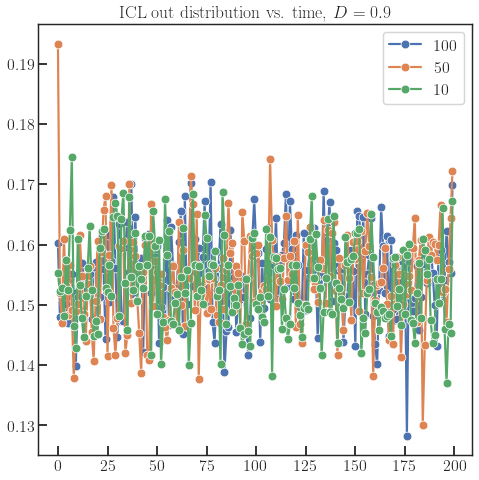

In [37]:
plt.figure(figsize=(dx,dy))
plt.title(r"Train loss vs. Fraction visible features $D$")
sns.lineplot(x=D_visible_fracs, y=train_losses, hue=Ns,marker='o')
plt.show()
plt.figure(figsize=(dx,dy))
plt.title(r"ICL in distribution vs. Fraction visible features $D$")
sns.lineplot(x=D_visible_fracs, y=icl_indistribution_losses, hue=Ns,marker='o')
plt.show()
plt.figure(figsize=(dx,dy))
plt.title(r"ICL out distribution vs. Fraction visible features $D$")
sns.lineplot(x=D_visible_fracs, y=icl_outdistribution_losses, hue=Ns,marker='o')
plt.show()
plt.figure(figsize=(dx,dy))
plt.title(r"IWL in distribution vs. Fraction visible features $D$")
sns.lineplot(x=D_visible_fracs, y=iwl_indistribution_losses, hue=Ns,marker='o')
plt.show()
plt.figure(figsize=(dx,dy))
plt.title(r"IWL out distribution vs. Fraction visible features $D$")
sns.lineplot(x=D_visible_fracs, y=iwl_outdistribution_losses, hue=Ns,marker='o')
plt.show()
plt.figure(figsize=(dx,dy))
plt.title(r"Train loss vs. time, $D=0.9$")
print(len(time),len(train_losses_vs_time))
sns.lineplot(x=time, y=train_losses_vs_time, hue=Ns_time,marker='o', errorbar=None)
plt.show()
plt.figure(figsize=(dx,dy))
plt.title(r"ICL in distribution vs. time, $D=0.9$")
sns.lineplot(x=time, y=icl_indistribution_losses_vs_time, hue=Ns_time,marker='o', errorbar=None)
plt.show()
plt.figure(figsize=(dx,dy))
plt.title(r"ICL out distribution vs. time, $D=0.9$")
sns.lineplot(x=time, y=icl_outdistribution_losses_vs_time, hue=Ns_time,marker='o', errorbar=None)
plt.show()

# Oct 14 results

## Seq generator

In [6]:
import torch
import utils
class Sequence(torch.utils.data.Dataset):
    def __init__(self, K, D,  
                 len_context = 1,
                len_data = 60000, skip_generating_betas=False):

        # if K < 40000:
        self.len_context = len_context
        self.D = D
    
        # x = rng.standard_normal((K, D)) * (1.0 / np.sqrt(D)) # shape: (K, D) 
        if skip_generating_betas == False:
            true_betas = torch.randn((K, D)) * (1.0 / np.sqrt(D)) # shape: (K, D)
            self.true_betas = true_betas
        self.K = K 
        self.D = D
        self.len_data = len_data
        
    def __len__(self):
        return self.len_data

    def __getitem__(self, task: int):
        task_ind = torch.randint(0, self.K, (1,)).item()
        beta_incontext = self.true_betas[task_ind].unsqueeze(1) # shape: (D, 1)
        x = torch.randn((self.len_context, self.D)) * (1.0 / np.sqrt(self.D)) # shape: (self.len_context, D) 
        noise = torch.randn((self.len_context, 1)) * args.sigma_xi
        y = torch.matmul(x, beta_incontext) + noise

        # concat x and y 
        samples = x#torch.cat([x, y], axis = 1) # shape: (self.len_context, D+1)
        # ytest = samples[-1, -1].clone() 
        # samples[-1, -1] = 0.0 # remove ytest from samples 
         
          
        return samples.type(torch.float32), y.type(torch.float32), beta_incontext.type(torch.float32)  
args = utils.dotdict()
args.K = 100000
args.D_sum = 50
args.len_context = 100
train_dataset = Sequence(K=args.K, D=args.D_sum, len_context=args.len_context) 

In [10]:
from glob import glob
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict
import numpy as np
sns.set(context='talk', font_scale=1.0,font = "Arial",color_codes=True, palette='deep', style='ticks', rc={'mathtext.fontset': 'cm', 'xtick.direction': 'in','ytick.direction': 'in', 'axes.linewidth': 1.5, 'figure.dpi':70, 'text.usetex':True, 'font.size':24})
 
fnames = glob(f"./cache/linreg_oct14_specgen_transformer1layer_K_100000*")

cmap = plt.get_cmap('tab10')(range(10))
 
dx,dy = 8,8
Ns, D_visible_fracs = [], []
train_losses = []
icl_indistribution_losses, icl_outdistribution_losses = [], []
iwl_indistribution_losses, iwl_outdistribution_losses = [], []
train_losses_vs_time, icl_indistribution_losses_vs_time, icl_outdistribution_losses_vs_time = [], [], []
time = []
Ns_time = []
for run_i, fname in enumerate(fnames):
     
    try:
        with open(fname, 'rb') as f:
            r = pickle.load(f)
            N = str(r["args"]["len_context"]) 
            num_layers = str(r["args"]["num_layers"]) 
            print ("num_layers",num_layers)
            D_visible_frac = r["args"]["D_visible_frac"]
    except Exception as e:
        print(e)
        continue
    idx_fun = lambda x: x 
    f = idx_fun
    train_loss = f(r["logs"][-1]["train_loss"])
    icl_indistribution_loss = f(r["logs"][-1]["icl_indistribution_loss"])
    icl_outdistribution_loss = f(r["logs"][-1]["icl_outdistribution_loss"])
    iwl_indistribution_loss = f(r["logs"][-1]["iwl_indistribution_loss"])
    iwl_outdistribution_loss = f(r["logs"][-1]["iwl_outdistribution_loss"])
    train_losses.append(train_loss)
    icl_indistribution_losses.append(icl_indistribution_loss)
    icl_outdistribution_losses.append(icl_outdistribution_loss)
    iwl_indistribution_losses.append(iwl_indistribution_loss)
    iwl_outdistribution_losses.append(iwl_outdistribution_loss)
    if D_visible_frac==0.9:
        icl_indistribution_losses_vs_time.extend([f(i["icl_indistribution_loss"]) for i in r["logs"]])
        icl_outdistribution_losses_vs_time.extend([f(i["icl_outdistribution_loss"]) for i in r["logs"]])
        train_losses_vs_time.extend([f(i["train_loss"]) for i in r["logs"]])
        Ns_time.extend([N]*len(r["logs"]))
        time.extend([i["epoch"] for i in r["logs"]])
    Ns.append(N)
    D_visible_fracs.append(D_visible_frac)



num_layers 12
num_layers 12
num_layers 12
num_layers 1
num_layers 12
num_layers 12
num_layers 1
num_layers 1
num_layers 1
num_layers 12
num_layers 1
num_layers 1
num_layers 1
num_layers 1
num_layers 1
num_layers 12
num_layers 1
num_layers 12
num_layers 12
num_layers 1
num_layers 1
num_layers 12
num_layers 12
num_layers 12
num_layers 1
num_layers 1
num_layers 1
num_layers 1
num_layers 1
num_layers 12
num_layers 12
num_layers 1
num_layers 12
num_layers 1
num_layers 1
num_layers 12
num_layers 1
num_layers 1
num_layers 1
num_layers 1
num_layers 1
num_layers 1
num_layers 1
num_layers 1
num_layers 12
num_layers 12
num_layers 12
num_layers 12
num_layers 12
num_layers 12
num_layers 1
num_layers 1
num_layers 1
num_layers 1
num_layers 1


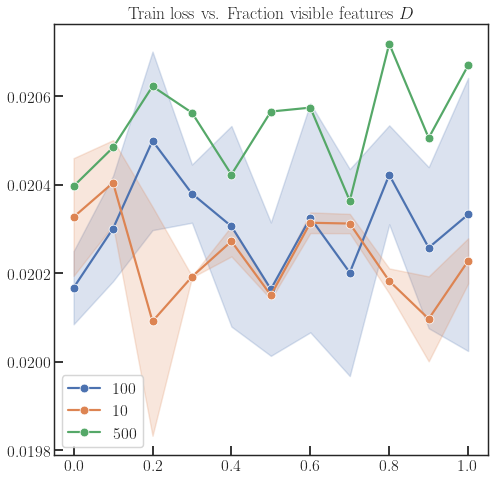

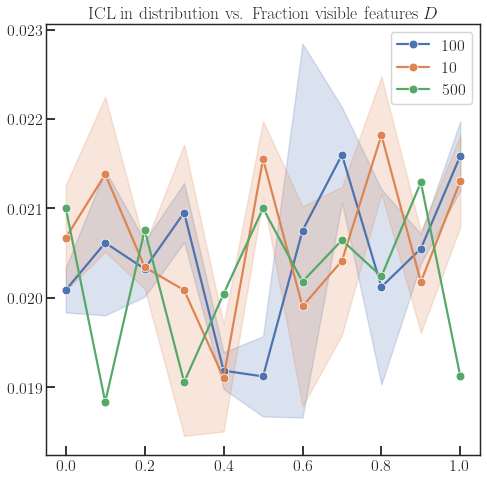

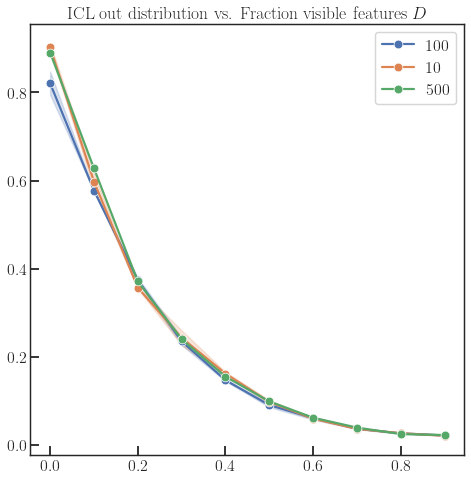

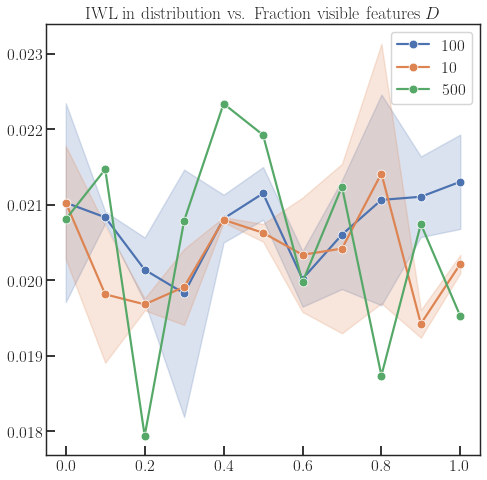

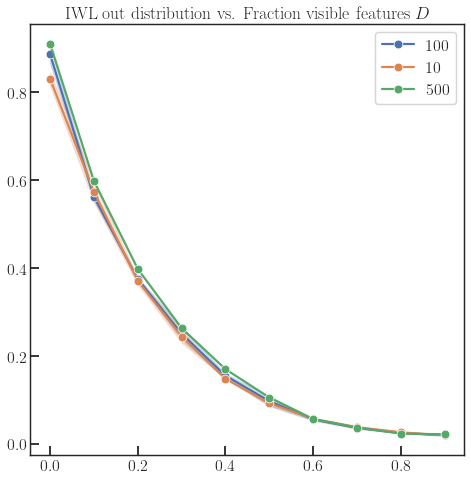

662 662


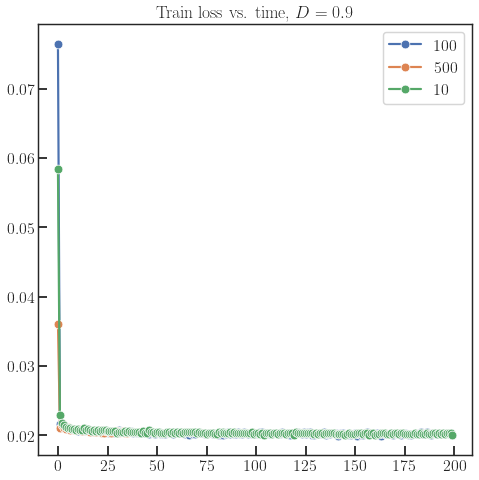

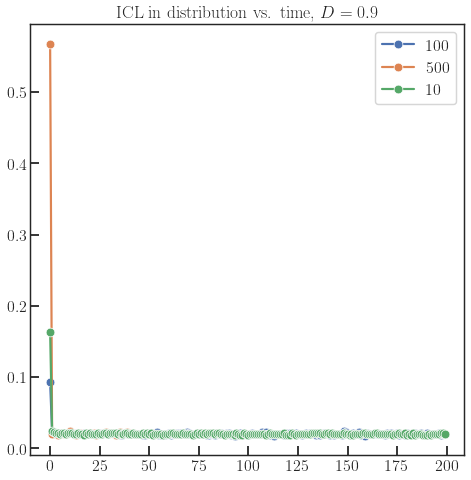

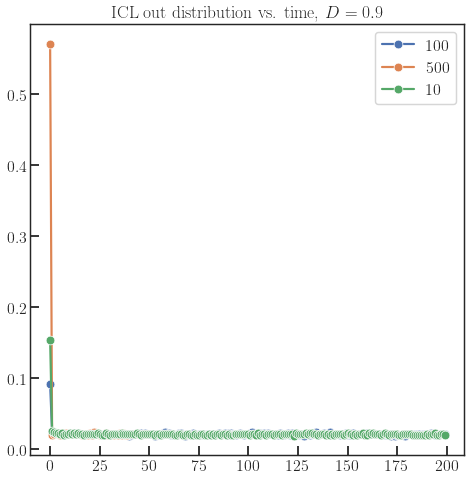

In [11]:
plt.figure(figsize=(dx,dy))
plt.title(r"Train loss vs. Fraction visible features $D$")
sns.lineplot(x=D_visible_fracs, y=train_losses, hue=Ns,marker='o')
plt.show()
plt.figure(figsize=(dx,dy))
plt.title(r"ICL in distribution vs. Fraction visible features $D$")
sns.lineplot(x=D_visible_fracs, y=icl_indistribution_losses, hue=Ns,marker='o')
plt.show()
plt.figure(figsize=(dx,dy))
plt.title(r"ICL out distribution vs. Fraction visible features $D$")
sns.lineplot(x=D_visible_fracs, y=icl_outdistribution_losses, hue=Ns,marker='o')
plt.show()
plt.figure(figsize=(dx,dy))
plt.title(r"IWL in distribution vs. Fraction visible features $D$")
sns.lineplot(x=D_visible_fracs, y=iwl_indistribution_losses, hue=Ns,marker='o')
plt.show()
plt.figure(figsize=(dx,dy))
plt.title(r"IWL out distribution vs. Fraction visible features $D$")
sns.lineplot(x=D_visible_fracs, y=iwl_outdistribution_losses, hue=Ns,marker='o')
plt.show()
plt.figure(figsize=(dx,dy))
plt.title(r"Train loss vs. time, $D=0.9$")
print(len(time),len(train_losses_vs_time))
sns.lineplot(x=time, y=train_losses_vs_time, hue=Ns_time,marker='o', errorbar=None)
plt.show()
plt.figure(figsize=(dx,dy))
plt.title(r"ICL in distribution vs. time, $D=0.9$")
sns.lineplot(x=time, y=icl_indistribution_losses_vs_time, hue=Ns_time,marker='o', errorbar=None)
plt.show()
plt.figure(figsize=(dx,dy))
plt.title(r"ICL out distribution vs. time, $D=0.9$")
sns.lineplot(x=time, y=icl_outdistribution_losses_vs_time, hue=Ns_time,marker='o', errorbar=None)
plt.show()

# Oct 21: GPT

In [14]:
import wandb
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
api = wandb.Api()
ENTITY = "anhhuyalex"
PROJECT = "renormalization"
# Filter runs by group name
runs = api.runs(f"{ENTITY}/{PROJECT}", filters={"group": "linreg_oct21_specgen"})

sns.set(context='talk', font_scale=1.0,font = "Arial",color_codes=True, palette='deep', style='ticks', rc={'mathtext.fontset': 'cm', 'xtick.direction': 'in','ytick.direction': 'in', 'axes.linewidth': 1.5, 'figure.dpi':70, 'text.usetex':True, 'font.size':24})
 
cmap = plt.get_cmap('tab10')(range(10))
 
dx,dy = 8,8
len_contexts, D_visible_fracs = [], []
train_losses = []
icl_indistribution_losses, icl_outdistribution_losses = [], []
iwl_indistribution_losses, iwl_outdistribution_losses = [], []
train_losses_vs_time, icl_indistribution_losses_vs_time, icl_outdistribution_losses_vs_time = [], [], []
time = []
Ns_time = []

# Download specific data from each run
for run in runs:
     
    if "train_loss" not in run.summary:
        continue
    try:
         
        len_contexts.append (run.config["len_context"])
        D_visible_fracs.append(run.config["D_visible"] / run.config["D_sum"])
        train_losses.append(run.summary["train_loss"])
        icl_indistribution_losses.append(run.summary["icl_indistribution_loss"])
        icl_outdistribution_losses.append(run.summary["icl_outdistribution_loss"])
        iwl_indistribution_losses.append(run.summary["iwl_indistribution_loss"])
        iwl_outdistribution_losses.append(run.summary["iwl_outdistribution_loss"])
        display(run.history())
#         if run.config["D_visible"] - 7 < 1e-2:
            
#             icl_indistribution_losses_vs_time.extend(run.history("icl_indistribution_loss"))
#             icl_outdistribution_losses_vs_time.extend(run.history("icl_outdistribution_loss"))
#             train_losses_vs_time.extend(run.history("train_loss"))
#             Ns_time.extend([run.config["len_context"]]*len(run.history("train_loss")))
#             time.extend(range(len(run.history("train_loss"))))
    except Exception as e:
        print(e)
datf = pd.DataFrame({"epochs": epochs, 
                    "len_context": len_context, "icl_val_top1": icl_val_top1
                    })
display(datf)

def plot(): 
    df = datf 
    sns.set_theme(style="whitegrid")
    fig,ax_epochs = plt.subplots(2, 2)
    for i, seq_len in enumerate([ 100, 200, 400, 800 ]): 
        df_seq_len = df[df["len_context"]==seq_len]
        sns.scatterplot( data=df_seq_len, x="epochs", ax = ax_epochs[i//2, i% 2])
        ax_epochs[i//2, i% 2].set_title(f"seq_len={seq_len}")
          
    # plt.ylim(0,1)
 
    # ax.legend(loc="lower right")
    plt.title("epochs to reach 0.95 icl histogram")
    plt.show()
 
plot()

,icl_outdistribution_loss,iwl_outdistribution_loss,epoch,_runtime,train_loss,_step,iwl_indistribution_loss,_timestamp,icl_indistribution_loss
0,0.787809,0.772944,0,7.570454,0.823001,0,0.755333,1.729526e+09,0.769334
1,0.769720,0.752476,1,12.128271,0.745256,1,0.722350,1.729526e+09,0.781898
2,0.779625,0.744518,2,16.689558,0.739077,2,0.719595,1.729526e+09,0.760893
3,0.786964,0.725116,3,21.272941,0.741360,3,0.745274,1.729526e+09,0.784634
4,0.792291,0.763651,4,25.872541,0.742439,4,0.725942,1.729526e+09,0.786204
...,...,...,...,...,...,...,...,...,...
395,0.762156,0.725123,395,1795.743524,0.745327,395,0.742049,1.729528e+09,0.769253
396,0.761739,0.741739,396,1800.254702,0.746131,396,0.748925,1.729528e+09,0.758979
397,0.758289,0.754653,397,1804.700549,0.743715,397,0.730876,1.729528e+09,0.767308
398,0.775614,0.728169,398,1809.157816,0.744558,398,0.738794,1.729528e+09,0.773207


,epoch,train_loss,icl_indistribution_loss,iwl_outdistribution_loss,_step,_runtime,_timestamp,icl_outdistribution_loss,iwl_indistribution_loss
0,0,0.747879,0.768828,0.749635,0,7.501860,1.729526e+09,0.775366,0.740044
1,1,0.70065,0.744171,0.720236,1,12.060189,1.729526e+09,0.739896,0.707816
2,2,0.697437,0.72901,0.70304,2,16.616729,1.729526e+09,0.747091,0.712505
3,3,0.699623,0.777206,0.672769,3,21.194870,1.729526e+09,0.734243,0.719248
4,4,0.698987,0.762066,0.701181,4,25.800705,1.729526e+09,0.75565,0.70646
...,...,...,...,...,...,...,...,...,...
395,395,NaN,NaN,NaN,395,1797.348312,1.729528e+09,NaN,NaN
396,396,NaN,NaN,NaN,396,1801.826251,1.729528e+09,NaN,NaN
397,397,NaN,NaN,NaN,397,1806.355137,1.729528e+09,NaN,NaN
398,398,NaN,NaN,NaN,398,1810.859684,1.729528e+09,NaN,NaN


,train_loss,_step,_timestamp,iwl_outdistribution_loss,_runtime,icl_indistribution_loss,icl_outdistribution_loss,iwl_indistribution_loss,epoch
0,0.831437,0,1.729526e+09,0.782468,7.437226,0.786383,0.820496,0.756082,0
1,0.739526,1,1.729526e+09,0.728629,11.776913,0.756426,0.797767,0.777626,1
2,0.738126,2,1.729526e+09,0.720775,16.165942,0.753146,0.79736,0.77004,2
3,0.733774,3,1.729526e+09,0.710562,20.513986,0.751077,0.764932,0.740129,3
4,0.742339,4,1.729526e+09,0.744266,24.846096,0.741793,0.776582,0.725607,4
...,...,...,...,...,...,...,...,...,...
395,NaN,395,1.729528e+09,NaN,1727.198360,NaN,NaN,NaN,395
396,NaN,396,1.729528e+09,NaN,1731.602705,NaN,NaN,NaN,396
397,NaN,397,1.729528e+09,NaN,1735.906642,NaN,NaN,NaN,397
398,NaN,398,1.729528e+09,NaN,1740.171117,NaN,NaN,NaN,398


,train_loss,iwl_outdistribution_loss,_runtime,_timestamp,icl_indistribution_loss,icl_outdistribution_loss,epoch,iwl_indistribution_loss,_step
0,0.756038,0.730762,7.623549,1.729526e+09,0.763853,0.79076,0,0.713031,0
1,0.692922,0.699185,12.269720,1.729526e+09,0.770774,0.775257,1,0.681625,1
2,0.691505,0.683972,16.895312,1.729526e+09,0.766018,0.770885,2,0.714604,2
3,0.691977,0.6744,21.552371,1.729526e+09,0.785858,0.768292,3,0.692292,3
4,0.68934,0.681318,26.113856,1.729526e+09,0.765317,0.776187,4,0.689655,4
...,...,...,...,...,...,...,...,...,...
395,NaN,NaN,1827.242163,1.729528e+09,NaN,NaN,395,NaN,395
396,NaN,NaN,1831.787630,1.729528e+09,NaN,NaN,396,NaN,396
397,NaN,NaN,1836.284417,1.729528e+09,NaN,NaN,397,NaN,397
398,NaN,NaN,1840.731382,1.729528e+09,NaN,NaN,398,NaN,398


,iwl_indistribution_loss,icl_outdistribution_loss,iwl_outdistribution_loss,train_loss,icl_indistribution_loss,_step,_runtime,epoch,_timestamp
0,0.763227,0.768336,0.770439,0.89884,0.790405,0,7.494289,0,1.729526e+09
1,0.77515,0.768381,0.771373,0.764533,0.756662,1,12.041634,1,1.729526e+09
2,0.738521,0.754531,0.772425,0.764103,0.756717,2,16.608795,2,1.729526e+09
3,0.779246,0.761191,0.756968,0.765141,0.752821,3,21.157703,3,1.729526e+09
4,0.758042,0.774167,0.75952,0.759426,0.733746,4,25.736364,4,1.729526e+09
...,...,...,...,...,...,...,...,...,...
395,NaN,NaN,NaN,NaN,NaN,395,1793.655020,395,1.729528e+09
396,NaN,NaN,NaN,NaN,NaN,396,1798.224044,396,1.729528e+09
397,NaN,NaN,NaN,NaN,NaN,397,1802.767625,397,1.729528e+09
398,NaN,NaN,NaN,NaN,NaN,398,1807.266399,398,1.729528e+09


,icl_outdistribution_loss,iwl_outdistribution_loss,_step,_runtime,_timestamp,epoch,train_loss,icl_indistribution_loss,iwl_indistribution_loss
0,0.808329,0.782292,0,7.289612,1.729526e+09,0,0.819157,0.793740,0.786851
1,0.752891,0.759226,1,11.505411,1.729526e+09,1,0.748720,0.797137,0.727178
2,0.779877,0.742635,2,15.775857,1.729526e+09,2,0.751695,0.747762,0.775365
3,0.776639,0.746858,3,20.017685,1.729526e+09,3,0.747793,0.808872,0.756084
4,0.779347,0.780479,4,24.316531,1.729526e+09,4,0.743285,0.759616,0.723726
...,...,...,...,...,...,...,...,...,...
395,0.780015,0.728020,395,1696.207888,1.729528e+09,395,0.745622,0.761443,0.723578
396,0.783885,0.765035,396,1700.528153,1.729528e+09,396,0.746415,0.693994,0.754816
397,0.758444,0.734085,397,1704.774687,1.729528e+09,397,0.742590,0.771516,0.758193
398,0.800213,0.752274,398,1709.008229,1.729528e+09,398,0.743075,0.754236,0.780194


,_step,icl_indistribution_loss,iwl_outdistribution_loss,train_loss,iwl_indistribution_loss,epoch,_runtime,_timestamp,icl_outdistribution_loss
0,0,0.775068,0.794209,0.805438,0.817975,0,7.568978,1.729526e+09,0.782005
1,1,0.752523,0.748091,0.756863,0.726517,1,12.178312,1.729526e+09,0.753427
2,2,0.771878,0.758709,0.751905,0.763609,2,16.842212,1.729526e+09,0.762693
3,3,0.749639,0.745531,0.755659,0.728779,3,21.517049,1.729526e+09,0.749933
4,4,0.728328,0.751796,0.752102,0.763799,4,26.218496,1.729526e+09,0.756108
...,...,...,...,...,...,...,...,...,...
395,395,NaN,NaN,NaN,NaN,395,1820.774155,1.729528e+09,NaN
396,396,NaN,NaN,NaN,NaN,396,1825.352519,1.729528e+09,NaN
397,397,NaN,NaN,NaN,NaN,397,1829.902772,1.729528e+09,NaN
398,398,NaN,NaN,NaN,NaN,398,1834.472943,1.729528e+09,NaN


,_timestamp,iwl_indistribution_loss,icl_outdistribution_loss,iwl_outdistribution_loss,_step,_runtime,train_loss,icl_indistribution_loss,epoch
0,1.729526e+09,0.798345,0.771482,0.774309,0,7.474858,0.805715,0.760389,0
1,1.729526e+09,0.745576,0.769102,0.751111,1,11.936601,0.748950,0.752105,1
2,1.729526e+09,0.749473,0.764353,0.751856,2,16.389592,0.751105,0.752766,2
3,1.729526e+09,0.731922,0.753699,0.757270,3,20.862228,0.752424,0.727373,3
4,1.729526e+09,0.740337,0.738868,0.748527,4,25.329226,0.751057,0.721388,4
...,...,...,...,...,...,...,...,...,...
395,1.729528e+09,0.754536,0.742982,0.781202,395,1770.880781,0.748546,0.749133,395
396,1.729528e+09,0.768738,0.745453,0.774723,396,1775.296244,0.747931,0.733878,396
397,1.729528e+09,0.757678,0.754936,0.762287,397,1779.735021,0.749721,0.742703,397
398,1.729528e+09,0.772091,0.743758,0.781824,398,1784.157646,0.751742,0.734183,398


,_runtime,iwl_outdistribution_loss,icl_indistribution_loss,epoch,train_loss,iwl_indistribution_loss,_step,icl_outdistribution_loss,_timestamp
0,7.486063,0.80154,0.781084,0,0.808656,0.753236,0,0.818484,1.729526e+09
1,11.997594,0.790353,0.770426,1,0.761135,0.74812,1,0.748996,1.729526e+09
2,16.520056,0.814336,0.770754,2,0.754857,0.787998,2,0.767137,1.729526e+09
3,21.043589,0.805521,0.769219,3,0.756103,0.754838,3,0.781975,1.729526e+09
4,25.602511,0.739727,0.759986,4,0.758501,0.767435,4,0.78723,1.729526e+09
...,...,...,...,...,...,...,...,...,...
395,1790.578619,NaN,NaN,395,NaN,NaN,395,NaN,1.729528e+09
396,1795.087485,NaN,NaN,396,NaN,NaN,396,NaN,1.729528e+09
397,1799.575286,NaN,NaN,397,NaN,NaN,397,NaN,1.729528e+09
398,1804.062607,NaN,NaN,398,NaN,NaN,398,NaN,1.729528e+09


,_step,_timestamp,icl_outdistribution_loss,iwl_outdistribution_loss,epoch,_runtime,icl_indistribution_loss,iwl_indistribution_loss,train_loss
0,0,1.729525e+09,0.804138,0.776102,0,7.568112,0.789397,0.772238,0.817865
1,1,1.729525e+09,0.762322,0.729324,1,12.238340,0.761813,0.728036,0.725787
2,2,1.729525e+09,0.772546,0.7426,2,16.874510,0.764225,0.756452,0.724807
3,3,1.729525e+09,0.758218,0.74016,3,21.480093,0.771823,0.724509,0.725064
4,4,1.729525e+09,0.776674,0.77226,4,26.096011,0.743933,0.74993,0.728774
...,...,...,...,...,...,...,...,...,...
395,395,1.729527e+09,NaN,NaN,395,1837.542287,NaN,NaN,NaN
396,396,1.729527e+09,NaN,NaN,396,1842.078929,NaN,NaN,NaN
397,397,1.729527e+09,NaN,NaN,397,1846.599273,NaN,NaN,NaN
398,398,1.729527e+09,NaN,NaN,398,1851.142275,NaN,NaN,NaN


,train_loss,iwl_indistribution_loss,icl_outdistribution_loss,_timestamp,iwl_outdistribution_loss,epoch,_runtime,_step,icl_indistribution_loss
0,0.843669,0.760501,0.793864,1.729525e+09,0.75266,0,7.468029,0,0.834061
1,0.728946,0.712726,0.764872,1.729525e+09,0.747609,1,11.941348,1,0.745864
2,0.724051,0.699154,0.774126,1.729525e+09,0.719088,2,16.438991,2,0.731108
3,0.723884,0.7313,0.759835,1.729525e+09,0.745085,3,20.900134,3,0.776737
4,0.722639,0.725571,0.771424,1.729525e+09,0.743167,4,25.423026,4,0.75829
...,...,...,...,...,...,...,...,...,...
395,NaN,NaN,NaN,1.729527e+09,NaN,395,1799.885810,395,NaN
396,NaN,NaN,NaN,1.729527e+09,NaN,396,1804.427166,396,NaN
397,NaN,NaN,NaN,1.729527e+09,NaN,397,1808.968107,397,NaN
398,NaN,NaN,NaN,1.729527e+09,NaN,398,1813.480930,398,NaN


,_step,_runtime,train_loss,iwl_indistribution_loss,epoch,icl_outdistribution_loss,iwl_outdistribution_loss,_timestamp,icl_indistribution_loss
0,0,7.505423,0.812546,0.804733,0,0.812503,0.844507,1.729525e+09,0.754507
1,1,12.004359,0.780036,0.783375,1,0.776967,0.780918,1.729525e+09,0.792078
2,2,16.527106,0.782008,0.798731,2,0.766588,0.74738,1.729525e+09,0.691359
3,3,21.050774,0.77913,0.762057,3,0.750024,0.853086,1.729525e+09,0.712877
4,4,25.590010,0.779151,0.801598,4,0.79906,0.817317,1.729525e+09,0.743272
...,...,...,...,...,...,...,...,...,...
395,395,1799.790333,NaN,NaN,395,NaN,NaN,1.729526e+09,NaN
396,396,1804.305323,NaN,NaN,396,NaN,NaN,1.729526e+09,NaN
397,397,1808.810131,NaN,NaN,397,NaN,NaN,1.729526e+09,NaN
398,398,1813.332599,NaN,NaN,398,NaN,NaN,1.729526e+09,NaN


,_runtime,iwl_outdistribution_loss,_step,train_loss,icl_indistribution_loss,icl_outdistribution_loss,epoch,_timestamp,iwl_indistribution_loss
0,7.650347,0.775324,0,0.801393,0.795030,0.804889,0,1.729524e+09,0.785878
1,12.196752,0.791297,1,0.752141,0.745837,0.771026,1,1.729524e+09,0.749471
2,16.839806,0.765301,2,0.751305,0.768234,0.750198,2,1.729524e+09,0.755317
3,21.418648,0.748280,3,0.748658,0.746104,0.765703,3,1.729525e+09,0.744440
4,26.018769,0.765494,4,0.752780,0.736870,0.778181,4,1.729525e+09,0.750549
...,...,...,...,...,...,...,...,...,...
395,1820.749418,0.753299,395,0.750404,0.752380,0.770593,395,1.729526e+09,0.767242
396,1825.251905,0.733889,396,0.749484,0.753612,0.778835,396,1.729526e+09,0.747944
397,1829.768363,0.744983,397,0.748166,0.748973,0.765781,397,1.729526e+09,0.746886
398,1834.333477,0.763944,398,0.750525,0.762313,0.758153,398,1.729526e+09,0.752941


,train_loss,_timestamp,iwl_indistribution_loss,_runtime,iwl_outdistribution_loss,icl_indistribution_loss,icl_outdistribution_loss,_step,epoch
0,0.795057,1.729524e+09,0.744731,7.422700,0.779026,0.778704,0.848813,0,0
1,0.724336,1.729524e+09,0.739694,11.877770,0.769054,0.752423,0.798885,1,1
2,0.729251,1.729524e+09,0.791513,16.344049,0.862628,0.806039,0.897659,2,2
3,0.725694,1.729524e+09,0.729631,20.802992,0.767974,0.777158,0.803144,3,3
4,0.722366,1.729524e+09,0.722108,25.280407,0.755628,0.767345,0.786716,4,4
...,...,...,...,...,...,...,...,...,...
395,NaN,1.729526e+09,NaN,1780.510042,NaN,NaN,NaN,395,395
396,NaN,1.729526e+09,NaN,1785.001596,NaN,NaN,NaN,396,396
397,NaN,1.729526e+09,NaN,1789.495251,NaN,NaN,NaN,397,397
398,NaN,1.729526e+09,NaN,1794.035910,NaN,NaN,NaN,398,398


,icl_indistribution_loss,iwl_indistribution_loss,_step,_runtime,icl_outdistribution_loss,iwl_outdistribution_loss,epoch,_timestamp,train_loss
0,0.765912,0.782108,0,7.452761,0.785396,0.805867,0,1.729524e+09,0.84036
1,0.749076,0.759397,1,11.855233,0.744286,0.777284,1,1.729524e+09,0.785389
2,0.76441,0.776905,2,16.309033,0.791618,0.790796,2,1.729524e+09,0.781763
3,0.759039,0.766826,3,20.744149,0.771164,0.808654,3,1.729524e+09,0.780976
4,0.745425,0.794966,4,25.211818,0.752807,0.795625,4,1.729524e+09,0.779029
...,...,...,...,...,...,...,...,...,...
395,NaN,NaN,395,1777.302180,NaN,NaN,395,1.729526e+09,NaN
396,NaN,NaN,396,1781.781211,NaN,NaN,396,1.729526e+09,NaN
397,NaN,NaN,397,1786.245016,NaN,NaN,397,1.729526e+09,NaN
398,NaN,NaN,398,1790.732875,NaN,NaN,398,1.729526e+09,NaN


,epoch,iwl_indistribution_loss,icl_indistribution_loss,_timestamp,train_loss,iwl_outdistribution_loss,icl_outdistribution_loss,_step,_runtime
0,0,0.790428,0.757269,1.729524e+09,0.857434,0.825832,0.807358,0,7.750117
1,1,0.814043,0.734565,1.729524e+09,0.787278,0.834587,0.773965,1,12.241549
2,2,0.779623,0.732097,1.729524e+09,0.783138,0.841465,0.783087,2,16.760911
3,3,0.784280,0.743690,1.729524e+09,0.784039,0.825282,0.782777,3,21.283402
4,4,0.796577,0.747145,1.729524e+09,0.781524,0.811807,0.764409,4,25.842550
...,...,...,...,...,...,...,...,...,...
395,395,0.797874,0.738992,1.729526e+09,0.788319,0.791822,0.745780,395,1808.085680
396,396,0.790048,0.712373,1.729526e+09,0.784901,0.835327,0.794649,396,1812.677799
397,397,0.802998,0.729203,1.729526e+09,0.784029,0.812765,0.783381,397,1817.290562
398,398,0.790380,0.730289,1.729526e+09,0.787602,0.841972,0.789760,398,1821.951707


,epoch,train_loss,icl_indistribution_loss,_step,iwl_indistribution_loss,icl_outdistribution_loss,iwl_outdistribution_loss,_runtime,_timestamp
0,0,0.839144,0.787158,0,0.792483,0.812287,0.805765,7.698375,1.729524e+09
1,1,0.768260,0.761255,1,0.765013,0.773138,0.775960,12.245667,1.729524e+09
2,2,0.766137,0.742592,2,0.777831,0.766644,0.795775,16.760083,1.729524e+09
3,3,0.767474,0.763053,3,0.749397,0.777620,0.796375,21.313150,1.729524e+09
4,4,0.768186,0.750408,4,0.767976,0.761100,0.773307,25.887650,1.729524e+09
...,...,...,...,...,...,...,...,...,...
395,395,0.766042,0.768003,395,0.771585,0.783412,0.802910,1821.606266,1.729526e+09
396,396,0.767601,0.779433,396,0.762900,0.779703,0.791405,1826.195390,1.729526e+09
397,397,0.766228,0.754348,397,0.758975,0.774533,0.793230,1830.822106,1.729526e+09
398,398,0.768677,0.748199,398,0.762112,0.776259,0.778269,1835.406105,1.729526e+09


,icl_indistribution_loss,iwl_outdistribution_loss,_step,iwl_indistribution_loss,_timestamp,train_loss,epoch,_runtime,icl_outdistribution_loss
0,0.772634,0.883489,0,0.771709,1.729524e+09,0.788958,0,7.312009,0.88282
1,0.758153,0.79141,1,0.767932,1.729524e+09,0.745424,1,11.620904,0.855976
2,0.762308,0.816684,2,0.719547,1.729524e+09,0.748734,2,15.971928,0.811169
3,0.758769,0.811337,3,0.728705,1.729524e+09,0.747163,3,20.391082,0.840425
4,0.752294,0.825976,4,0.749478,1.729524e+09,0.744448,4,24.777627,0.815343
...,...,...,...,...,...,...,...,...,...
395,NaN,NaN,395,NaN,1.729526e+09,NaN,395,1741.819980,NaN
396,NaN,NaN,396,NaN,1.729526e+09,NaN,396,1746.213532,NaN
397,NaN,NaN,397,NaN,1.729526e+09,NaN,397,1750.575254,NaN
398,NaN,NaN,398,NaN,1.729526e+09,NaN,398,1754.965644,NaN


,train_loss,icl_outdistribution_loss,_step,_runtime,_timestamp,icl_indistribution_loss,epoch,iwl_indistribution_loss,iwl_outdistribution_loss
0,0.767450,0.811467,0,7.567936,1.729524e+09,0.761116,0,0.766020,0.755899
1,0.719884,0.761598,1,12.109049,1.729524e+09,0.736872,1,0.703604,0.739063
2,0.720665,0.776751,2,16.701195,1.729524e+09,0.753236,2,0.723202,0.748505
3,0.723712,0.770293,3,21.373769,1.729524e+09,0.734963,3,0.751880,0.744150
4,0.719783,0.791369,4,25.974282,1.729524e+09,0.738344,4,0.710322,0.758194
...,...,...,...,...,...,...,...,...,...
395,0.719943,0.770560,395,1832.725234,1.729526e+09,0.734193,395,0.706341,0.767476
396,0.720819,0.761330,396,1837.388708,1.729526e+09,0.725876,396,0.724258,0.744485
397,0.720692,0.739322,397,1842.001580,1.729526e+09,0.734897,397,0.702825,0.747261
398,0.720019,0.782364,398,1846.612927,1.729526e+09,0.741897,398,0.710400,0.731407


,train_loss,iwl_outdistribution_loss,_step,_runtime,icl_outdistribution_loss,_timestamp,icl_indistribution_loss,iwl_indistribution_loss,epoch
0,0.799980,0.823682,0,7.415065,0.811161,1.729524e+09,0.746243,0.755589,0
1,0.753216,0.814431,1,11.878107,0.815937,1.729524e+09,0.755952,0.743281,1
2,0.755114,0.815185,2,16.351122,0.795165,1.729524e+09,0.766574,0.728471,2
3,0.750182,0.859502,3,20.807837,0.828296,1.729524e+09,0.745925,0.779163,3
4,0.746633,0.799651,4,25.282429,0.807281,1.729524e+09,0.744494,0.741696,4
...,...,...,...,...,...,...,...,...,...
395,0.752718,0.816300,395,1801.066781,0.850056,1.729526e+09,0.757241,0.724323,395
396,0.753054,0.824498,396,1805.620646,0.845306,1.729526e+09,0.769187,0.739167,396
397,0.750340,0.856569,397,1810.212776,0.831133,1.729526e+09,0.766853,0.750275,397
398,0.748347,0.817195,398,1814.746598,0.778406,1.729526e+09,0.757782,0.748487,398


,train_loss,epoch,iwl_indistribution_loss,icl_outdistribution_loss,_step,_runtime,_timestamp,icl_indistribution_loss,iwl_outdistribution_loss
0,0.824121,0,0.777926,0.85265,0,7.467727,1.729524e+09,0.782514,0.89447
1,0.762328,1,0.758118,0.872824,1,11.936285,1.729524e+09,0.758409,0.862109
2,0.758375,2,0.73539,0.855914,2,16.471043,1.729524e+09,0.778433,0.871265
3,0.758939,3,0.746076,0.906452,3,21.000957,1.729524e+09,0.745819,0.916816
4,0.760269,4,0.727357,0.837608,4,25.542563,1.729524e+09,0.771737,0.903851
...,...,...,...,...,...,...,...,...,...
395,NaN,395,NaN,NaN,395,1791.733618,1.729526e+09,NaN,NaN
396,NaN,396,NaN,NaN,396,1796.274256,1.729526e+09,NaN,NaN
397,NaN,397,NaN,NaN,397,1800.815958,1.729526e+09,NaN,NaN
398,NaN,398,NaN,NaN,398,1805.357770,1.729526e+09,NaN,NaN


,iwl_indistribution_loss,_timestamp,icl_indistribution_loss,_step,epoch,_runtime,train_loss,iwl_outdistribution_loss,icl_outdistribution_loss
0,0.795534,1.729524e+09,0.777959,0,0,7.469345,0.831408,0.847110,0.825075
1,0.776469,1.729524e+09,0.752774,1,1,11.876598,0.771575,0.807478,0.836475
2,0.755859,1.729524e+09,0.742091,2,2,16.278678,0.770713,0.823527,0.802587
3,0.770692,1.729524e+09,0.789951,3,3,20.771786,0.769968,0.823076,0.788493
4,0.756782,1.729524e+09,0.760024,4,4,25.321292,0.773506,0.821533,0.808943
...,...,...,...,...,...,...,...,...,...
395,0.787862,1.729526e+09,0.746670,395,395,1771.506882,0.773592,0.864308,0.802371
396,0.779886,1.729526e+09,0.742622,396,396,1775.883891,0.772115,0.805147,0.790602
397,0.765055,1.729526e+09,0.752339,397,397,1780.367726,0.779863,0.820145,0.792697
398,0.793307,1.729526e+09,0.768592,398,398,1784.806534,0.773278,0.851801,0.813472


,_step,icl_indistribution_loss,icl_outdistribution_loss,_runtime,train_loss,iwl_outdistribution_loss,epoch,_timestamp,iwl_indistribution_loss
0,0,0.747676,0.980146,7.515308,0.902686,1.057231,0,1.729524e+09,0.802441
1,1,0.782704,0.968248,11.904799,0.823303,1.149110,1,1.729524e+09,0.827707
2,2,0.760356,0.958851,16.332222,0.808081,1.008945,2,1.729524e+09,0.804706
3,3,0.727017,0.946090,20.740448,0.802632,1.073919,3,1.729524e+09,0.781873
4,4,0.755885,0.934447,25.182072,0.803531,1.027710,4,1.729524e+09,0.764909
...,...,...,...,...,...,...,...,...,...
395,395,0.771574,0.977036,1761.728312,0.800502,1.075456,395,1.729526e+09,0.798051
396,396,0.769899,0.943928,1766.287314,0.799971,1.032848,396,1.729526e+09,0.791555
397,397,0.781006,0.958604,1770.742918,0.800779,1.010325,397,1.729526e+09,0.817378
398,398,0.788325,0.941321,1775.236010,0.802530,1.014873,398,1.729526e+09,0.814041


,_step,epoch,_timestamp,iwl_indistribution_loss,iwl_outdistribution_loss,train_loss,icl_indistribution_loss,icl_outdistribution_loss,_runtime
0,0,0,1.729524e+09,0.796493,0.859548,0.794686,0.787672,0.872314,7.570006
1,1,1,1.729524e+09,0.741223,0.856393,0.748140,0.754439,0.821039,12.013830
2,2,2,1.729524e+09,0.748605,0.832492,0.744863,0.744576,0.844423,16.470868
3,3,3,1.729524e+09,0.736349,0.844191,0.742773,0.741933,0.833821,20.936813
4,4,4,1.729524e+09,0.722957,0.853657,0.743853,0.757317,0.871756,25.397288
...,...,...,...,...,...,...,...,...,...
395,395,395,1.729526e+09,0.747091,0.851003,0.753565,0.748910,0.846839,1787.510524
396,396,396,1.729526e+09,0.730212,0.866153,0.743179,0.755529,0.826634,1792.095398
397,397,397,1.729526e+09,0.734597,0.860390,0.747757,0.746941,0.838865,1796.669570
398,398,398,1.729526e+09,0.746909,0.870989,0.748579,0.743644,0.835839,1801.216226


,iwl_outdistribution_loss,_timestamp,train_loss,icl_outdistribution_loss,_runtime,epoch,iwl_indistribution_loss,_step,icl_indistribution_loss
0,0.789216,1.729524e+09,0.873096,0.798499,7.635585,0,0.778113,0,0.816794
1,0.757268,1.729524e+09,0.754366,0.765823,12.344330,1,0.744163,1,0.751777
2,0.758235,1.729524e+09,0.754241,0.765962,17.059116,2,0.75939,2,0.768377
3,0.775999,1.729524e+09,0.754295,0.754766,21.806515,3,0.741698,3,0.777232
4,0.754737,1.729524e+09,0.75318,0.754149,26.509772,4,0.749629,4,0.77207
...,...,...,...,...,...,...,...,...,...
395,NaN,1.729526e+09,NaN,NaN,1875.529187,395,NaN,395,NaN
396,NaN,1.729526e+09,NaN,NaN,1880.338501,396,NaN,396,NaN
397,NaN,1.729526e+09,NaN,NaN,1885.095537,397,NaN,397,NaN
398,NaN,1.729526e+09,NaN,NaN,1889.801501,398,NaN,398,NaN


,icl_outdistribution_loss,_step,_runtime,_timestamp,train_loss,icl_indistribution_loss,iwl_outdistribution_loss,epoch,iwl_indistribution_loss
0,0.798175,0,7.575005,1.729523e+09,0.812954,0.750314,0.772975,0,0.774554
1,0.760258,1,12.144664,1.729523e+09,0.749723,0.768938,0.760228,1,0.740383
2,0.755640,2,16.771432,1.729523e+09,0.751088,0.742953,0.766264,2,0.742142
3,0.758753,3,21.333613,1.729523e+09,0.749006,0.745809,0.730871,3,0.751846
4,0.747110,4,25.923003,1.729523e+09,0.747217,0.770836,0.748994,4,0.750578
...,...,...,...,...,...,...,...,...,...
395,0.764624,395,1815.724718,1.729525e+09,0.743976,0.770151,0.747566,395,0.761455
396,0.746290,396,1820.360773,1.729525e+09,0.747112,0.757986,0.728899,396,0.748521
397,0.738405,397,1825.023942,1.729525e+09,0.744495,0.764431,0.757531,397,0.771210
398,0.774152,398,1829.642843,1.729525e+09,0.747322,0.755771,0.725349,398,0.732705


,_step,train_loss,icl_indistribution_loss,iwl_indistribution_loss,iwl_outdistribution_loss,epoch,_runtime,_timestamp,icl_outdistribution_loss
0,0,0.816921,0.755296,0.765366,0.738339,0,7.346423,1.729523e+09,0.796498
1,1,0.751254,0.725640,0.776481,0.776740,1,11.680459,1.729523e+09,0.752436
2,2,0.752150,0.775397,0.739748,0.742005,2,16.091531,1.729523e+09,0.741463
3,3,0.755245,0.759992,0.769250,0.755562,3,20.454302,1.729523e+09,0.747517
4,4,0.756819,0.749419,0.717582,0.738456,4,24.843492,1.729523e+09,0.753440
...,...,...,...,...,...,...,...,...,...
395,395,0.744949,0.772058,0.728897,0.738803,395,1753.115469,1.729525e+09,0.747150
396,396,0.752147,0.755922,0.762394,0.721846,396,1757.510969,1.729525e+09,0.740513
397,397,0.751854,0.754871,0.776701,0.732206,397,1762.020739,1.729525e+09,0.784767
398,398,0.752018,0.761736,0.737045,0.750612,398,1766.429587,1.729525e+09,0.752296


,epoch,train_loss,_runtime,_timestamp,icl_outdistribution_loss,iwl_indistribution_loss,iwl_outdistribution_loss,_step,icl_indistribution_loss
0,0,0.832651,7.668260,1.729523e+09,0.758538,0.768307,0.76211,0,0.780565
1,1,0.749031,12.287274,1.729523e+09,0.761547,0.753332,0.760283,1,0.749527
2,2,0.751111,16.938452,1.729523e+09,0.763035,0.774086,0.715822,2,0.743621
3,3,0.748584,21.606543,1.729523e+09,0.74173,0.747268,0.757247,3,0.764634
4,4,0.751904,26.270184,1.729523e+09,0.760824,0.739011,0.754742,4,0.754184
...,...,...,...,...,...,...,...,...,...
395,395,NaN,1871.396236,1.729525e+09,NaN,NaN,NaN,395,NaN
396,396,NaN,1876.138393,1.729525e+09,NaN,NaN,NaN,396,NaN
397,397,NaN,1880.858338,1.729525e+09,NaN,NaN,NaN,397,NaN
398,398,NaN,1885.633497,1.729525e+09,NaN,NaN,NaN,398,NaN


,icl_outdistribution_loss,iwl_outdistribution_loss,icl_indistribution_loss,_runtime,train_loss,iwl_indistribution_loss,_step,epoch,_timestamp
0,0.752326,0.777201,0.741266,7.506989,0.786912,0.756332,0,0,1.729523e+09
1,0.738195,0.758078,0.751118,11.991648,0.750487,0.734747,1,1,1.729523e+09
2,0.734657,0.750984,0.725089,16.502734,0.752739,0.758418,2,2,1.729523e+09
3,0.731736,0.773660,0.735847,21.064533,0.751235,0.728372,3,3,1.729523e+09
4,0.748845,0.739307,0.760812,25.645310,0.750961,0.720435,4,4,1.729523e+09
...,...,...,...,...,...,...,...,...,...
395,0.732516,0.734332,0.751535,1795.072087,0.750808,0.762693,395,395,1.729524e+09
396,0.747041,0.743146,0.748621,1799.580526,0.750512,0.754693,396,396,1.729524e+09
397,0.741687,0.739438,0.729857,1804.065565,0.744386,0.755666,397,397,1.729524e+09
398,0.742134,0.777324,0.755117,1808.574536,0.749694,0.754013,398,398,1.729524e+09


,train_loss,_step,icl_indistribution_loss,icl_outdistribution_loss,epoch,iwl_indistribution_loss,iwl_outdistribution_loss,_runtime,_timestamp
0,0.813464,0,0.762762,0.764565,0,0.77465,0.771883,7.609544,1.729522e+09
1,0.750024,1,0.742711,0.750087,1,0.78764,0.734019,12.024081,1.729522e+09
2,0.749244,2,0.757482,0.779789,2,0.718095,0.729441,16.449085,1.729522e+09
3,0.750043,3,0.75771,0.784526,3,0.776084,0.764712,20.847213,1.729522e+09
4,0.749488,4,0.762944,0.76215,4,0.742324,0.780276,25.283986,1.729522e+09
...,...,...,...,...,...,...,...,...,...
395,NaN,395,NaN,NaN,395,NaN,NaN,1757.701105,1.729524e+09
396,NaN,396,NaN,NaN,396,NaN,NaN,1762.186450,1.729524e+09
397,NaN,397,NaN,NaN,397,NaN,NaN,1766.612715,1.729524e+09
398,NaN,398,NaN,NaN,398,NaN,NaN,1771.035123,1.729524e+09


,iwl_outdistribution_loss,epoch,_runtime,_timestamp,icl_indistribution_loss,iwl_indistribution_loss,_step,train_loss,icl_outdistribution_loss
0,0.770423,0,7.729079,1.729522e+09,0.773326,0.772349,0,0.774509,0.773637
1,0.743004,1,12.285229,1.729522e+09,0.737612,0.758995,1,0.755537,0.751129
2,0.769975,2,16.832553,1.729522e+09,0.758101,0.764121,2,0.748099,0.748392
3,0.767822,3,21.370255,1.729522e+09,0.74725,0.755064,3,0.748578,0.754965
4,0.75576,4,25.962035,1.729522e+09,0.759987,0.753012,4,0.750186,0.761731
...,...,...,...,...,...,...,...,...,...
395,NaN,395,1815.965345,1.729524e+09,NaN,NaN,395,NaN,NaN
396,NaN,396,1820.558812,1.729524e+09,NaN,NaN,396,NaN,NaN
397,NaN,397,1825.161134,1.729524e+09,NaN,NaN,397,NaN,NaN
398,NaN,398,1829.760380,1.729524e+09,NaN,NaN,398,NaN,NaN


,train_loss,icl_indistribution_loss,iwl_indistribution_loss,icl_outdistribution_loss,_step,_timestamp,epoch,iwl_outdistribution_loss,_runtime
0,0.819641,0.765216,0.739003,0.781952,0,1.729522e+09,0,0.766326,7.501101
1,0.755864,0.751139,0.763044,0.763011,1,1.729522e+09,1,0.736906,11.961280
2,0.752580,0.745386,0.778456,0.741922,2,1.729522e+09,2,0.765864,16.515821
3,0.753545,0.754053,0.767046,0.743877,3,1.729522e+09,3,0.768280,21.065753
4,0.751837,0.760824,0.766441,0.727700,4,1.729522e+09,4,0.787034,25.562775
...,...,...,...,...,...,...,...,...,...
395,0.752402,0.736628,0.763904,0.763987,395,1.729524e+09,395,0.767385,1792.129226
396,0.751861,0.752609,0.731423,0.773703,396,1.729524e+09,396,0.772574,1796.690464
397,0.751206,0.764008,0.757936,0.750586,397,1.729524e+09,397,0.766514,1801.205317
398,0.753328,0.763381,0.742198,0.731981,398,1.729524e+09,398,0.775536,1805.713480


,icl_outdistribution_loss,icl_indistribution_loss,_runtime,epoch,train_loss,iwl_indistribution_loss,iwl_outdistribution_loss,_step,_timestamp
0,0.819800,0.777682,7.723397,0,0.852617,0.782973,0.795104,0,1.729522e+09
1,0.795754,0.746066,12.360917,1,0.752237,0.737553,0.738353,1,1.729522e+09
2,0.769693,0.772782,17.032255,2,0.751106,0.773517,0.760191,2,1.729522e+09
3,0.756650,0.731840,21.699969,3,0.753622,0.762112,0.753764,3,1.729522e+09
4,0.762342,0.760478,26.362250,4,0.751479,0.746276,0.745712,4,1.729522e+09
...,...,...,...,...,...,...,...,...,...
395,0.747575,0.753577,1856.922818,395,0.755290,0.755412,0.765795,395,1.729524e+09
396,0.757313,0.763801,1861.691621,396,0.750383,0.752994,0.752034,396,1.729524e+09
397,0.751497,0.765686,1866.394884,397,0.750541,0.751427,0.743129,397,1.729524e+09
398,0.747742,0.752249,1871.022481,398,0.751865,0.750292,0.740702,398,1.729524e+09


,_runtime,train_loss,icl_indistribution_loss,icl_outdistribution_loss,_step,epoch,_timestamp,iwl_indistribution_loss,iwl_outdistribution_loss
0,7.523427,0.801673,0.804955,0.757042,0,0,1.729522e+09,0.807322,0.794741
1,11.921614,0.758179,0.797189,0.771275,1,1,1.729522e+09,0.763199,0.781270
2,16.369705,0.750202,0.743916,0.755288,2,2,1.729522e+09,0.768403,0.815778
3,20.809308,0.750595,0.760169,0.793760,3,3,1.729522e+09,0.750496,0.753252
4,25.243338,0.744858,0.741173,0.772896,4,4,1.729522e+09,0.756598,0.742384
...,...,...,...,...,...,...,...,...,...
395,1755.685290,0.749578,0.754816,0.758123,395,395,1.729524e+09,0.750553,0.762629
396,1760.167481,0.748097,0.780105,0.750301,396,396,1.729524e+09,0.700948,0.756217
397,1764.577594,0.752070,0.717637,0.737305,397,397,1.729524e+09,0.732400,0.756112
398,1768.992082,0.748080,0.736333,0.758511,398,398,1.729524e+09,0.746251,0.760643


,_step,_timestamp,train_loss,_runtime,iwl_indistribution_loss,icl_outdistribution_loss,epoch,icl_indistribution_loss,iwl_outdistribution_loss
0,0,1.729522e+09,0.803397,7.379486,0.754331,0.751382,0,0.780448,0.773047
1,1,1.729522e+09,0.759160,11.730529,0.755208,0.767478,1,0.754896,0.766418
2,2,1.729522e+09,0.758245,16.060995,0.744025,0.775720,2,0.752130,0.785087
3,3,1.729522e+09,0.754758,20.398603,0.748597,0.759552,3,0.745520,0.733808
4,4,1.729522e+09,0.757265,24.761881,0.746589,0.784266,4,0.766596,0.737245
...,...,...,...,...,...,...,...,...,...
395,395,1.729524e+09,0.754629,1746.784634,0.745424,0.764571,395,0.748198,0.759168
396,396,1.729524e+09,0.753187,1751.085617,0.755500,0.780540,396,0.754234,0.770359
397,397,1.729524e+09,0.755698,1755.406082,0.761567,0.777358,397,0.760655,0.787509
398,398,1.729524e+09,0.755175,1759.766470,0.750481,0.755590,398,0.733458,0.788660


,epoch,_step,train_loss,icl_indistribution_loss,icl_outdistribution_loss,iwl_indistribution_loss,iwl_outdistribution_loss,_runtime,_timestamp
0,0,0,0.805987,0.775778,0.801041,0.791927,0.779136,7.329359,1.729522e+09
1,1,1,0.763655,0.783508,0.786778,0.756842,0.795232,11.566373,1.729522e+09
2,2,2,0.754585,0.778789,0.803518,0.740746,0.776827,15.795098,1.729522e+09
3,3,3,0.751962,0.769662,0.759229,0.778225,0.766104,20.052224,1.729522e+09
4,4,4,0.752826,0.784171,0.774840,0.723420,0.778345,24.338112,1.729522e+09
...,...,...,...,...,...,...,...,...,...
395,395,395,0.749151,0.758104,0.789956,0.769526,0.755926,1711.015225,1.729524e+09
396,396,396,0.751735,0.753009,0.766430,0.710078,0.755306,1715.293131,1.729524e+09
397,397,397,0.753493,0.726289,0.759853,0.760353,0.782422,1719.602795,1.729524e+09
398,398,398,0.749848,0.771435,0.817991,0.722488,0.784164,1723.871719,1.729524e+09


,_timestamp,icl_indistribution_loss,_step,epoch,_runtime,train_loss,iwl_indistribution_loss,icl_outdistribution_loss,iwl_outdistribution_loss
0,1.729522e+09,0.787541,0,0,7.630605,0.851422,0.740796,0.790468,0.779450
1,1.729522e+09,0.730789,1,1,12.210102,0.748646,0.737279,0.774478,0.748264
2,1.729522e+09,0.769203,2,2,16.776963,0.749784,0.742754,0.783993,0.774954
3,1.729522e+09,0.734049,3,3,21.337415,0.753406,0.774401,0.759041,0.761797
4,1.729522e+09,0.748507,4,4,25.919007,0.748176,0.770754,0.767095,0.788824
...,...,...,...,...,...,...,...,...,...
395,1.729524e+09,0.744348,395,395,1812.620156,0.749723,0.730082,0.764004,0.761370
396,1.729524e+09,0.749981,396,396,1817.139277,0.748940,0.748302,0.765190,0.779761
397,1.729524e+09,0.731271,397,397,1821.751155,0.749951,0.743445,0.763849,0.743795
398,1.729524e+09,0.764917,398,398,1826.272506,0.747007,0.739385,0.761811,0.751786


,icl_indistribution_loss,epoch,_runtime,iwl_indistribution_loss,icl_outdistribution_loss,_step,_timestamp,train_loss,iwl_outdistribution_loss
0,0.767044,0,7.648657,0.756802,0.809964,0,1.729522e+09,0.813850,0.808769
1,0.754500,1,12.199919,0.748922,0.783467,1,1.729522e+09,0.753520,0.774902
2,0.747750,2,16.787645,0.748555,0.775712,2,1.729522e+09,0.753004,0.758948
3,0.758495,3,21.321801,0.795283,0.776507,3,1.729522e+09,0.752730,0.755170
4,0.764891,4,25.882067,0.744379,0.791111,4,1.729522e+09,0.753397,0.771679
...,...,...,...,...,...,...,...,...,...
395,0.768766,395,1821.826311,0.731869,0.765056,395,1.729524e+09,0.749189,0.772163
396,0.761398,396,1826.414513,0.751222,0.793064,396,1.729524e+09,0.751584,0.777645
397,0.757317,397,1830.958978,0.748784,0.761922,397,1.729524e+09,0.752502,0.767171
398,0.748030,398,1835.501236,0.774246,0.789347,398,1.729524e+09,0.750980,0.775657


,icl_outdistribution_loss,_step,icl_indistribution_loss,iwl_outdistribution_loss,_timestamp,train_loss,epoch,_runtime,iwl_indistribution_loss
0,0.793861,0,0.783853,0.779088,1.729522e+09,0.813610,0,7.605974,0.740492
1,0.782923,1,0.771203,0.781555,1.729522e+09,0.749340,1,12.021597,0.759228
2,0.779216,2,0.755215,0.739721,1.729522e+09,0.747417,2,16.495915,0.749349
3,0.766266,3,0.760982,0.755716,1.729522e+09,0.748446,3,20.924675,0.747364
4,0.761326,4,0.737464,0.741688,1.729522e+09,0.746085,4,25.336926,0.755857
...,...,...,...,...,...,...,...,...,...
395,0.784445,395,0.756818,0.755962,1.729524e+09,0.745697,395,1772.062654,0.757920
396,0.777058,396,0.768192,0.736496,1.729524e+09,0.749705,396,1776.481165,0.723560
397,0.765543,397,0.747332,0.773727,1.729524e+09,0.746962,397,1780.918278,0.770404
398,0.779486,398,0.742593,0.767178,1.729524e+09,0.749148,398,1785.350758,0.760082


,_step,_timestamp,icl_indistribution_loss,iwl_indistribution_loss,iwl_outdistribution_loss,icl_outdistribution_loss,epoch,_runtime,train_loss
0,0,1.729522e+09,0.779492,0.790664,0.804188,0.771398,0,7.543820,0.799348
1,1,1.729522e+09,0.748431,0.780018,0.792233,0.780090,1,11.948698,0.756861
2,2,1.729522e+09,0.712612,0.714170,0.804587,0.803746,2,16.374703,0.754251
3,3,1.729522e+09,0.774423,0.754563,0.785799,0.784883,3,20.768539,0.750488
4,4,1.729522e+09,0.769232,0.749924,0.811338,0.775383,4,25.142867,0.752956
...,...,...,...,...,...,...,...,...,...
395,395,1.729524e+09,0.720023,0.779202,0.798657,0.787014,395,1759.786299,0.752438
396,396,1.729524e+09,0.723403,0.722275,0.776367,0.765587,396,1764.195224,0.752359
397,397,1.729524e+09,0.780045,0.730737,0.786123,0.795865,397,1768.622540,0.751167
398,398,1.729524e+09,0.746651,0.738590,0.741829,0.809718,398,1773.042644,0.753477


,_step,train_loss,iwl_outdistribution_loss,icl_outdistribution_loss,icl_indistribution_loss,_timestamp,iwl_indistribution_loss,epoch,_runtime
0,0,0.834575,0.787728,0.794192,0.788459,1.729521e+09,0.770249,0,7.635006
1,1,0.752527,0.777919,0.790113,0.756654,1.729521e+09,0.735407,1,12.205228
2,2,0.755465,0.804050,0.766950,0.775625,1.729521e+09,0.728242,2,16.769324
3,3,0.750869,0.800142,0.757651,0.734528,1.729521e+09,0.769407,3,21.350068
4,4,0.748432,0.764642,0.790217,0.761526,1.729521e+09,0.770184,4,25.948514
...,...,...,...,...,...,...,...,...,...
395,395,0.753536,0.769968,0.775315,0.767387,1.729523e+09,0.743715,395,1817.092620
396,396,0.751727,0.781299,0.808515,0.761572,1.729523e+09,0.759175,396,1821.720345
397,397,0.750712,0.783154,0.795723,0.754321,1.729523e+09,0.765607,397,1826.295126
398,398,0.749324,0.792030,0.779210,0.759992,1.729523e+09,0.733964,398,1830.816813


,_timestamp,_runtime,train_loss,iwl_indistribution_loss,icl_outdistribution_loss,_step,epoch,iwl_outdistribution_loss,icl_indistribution_loss
0,1.729521e+09,7.439623,0.932571,0.792109,0.857401,0,0,0.872,0.771371
1,1.729521e+09,11.934901,0.753249,0.763697,0.859083,1,1,0.820317,0.752218
2,1.729521e+09,16.448470,0.751979,0.738208,0.838112,2,2,0.82662,0.733593
3,1.729521e+09,20.945348,0.753845,0.761782,0.81335,3,3,0.782809,0.735907
4,1.729521e+09,25.446638,0.75379,0.764506,0.806862,4,4,0.841013,0.733466
...,...,...,...,...,...,...,...,...,...
395,1.729523e+09,1794.590578,NaN,NaN,NaN,395,395,NaN,NaN
396,1.729523e+09,1799.153292,NaN,NaN,NaN,396,396,NaN,NaN
397,1.729523e+09,1803.688161,NaN,NaN,NaN,397,397,NaN,NaN
398,1.729523e+09,1808.221257,NaN,NaN,NaN,398,398,NaN,NaN


,epoch,_timestamp,icl_outdistribution_loss,train_loss,icl_indistribution_loss,_runtime,iwl_indistribution_loss,iwl_outdistribution_loss,_step
0,0,1.729521e+09,0.795488,0.799981,0.769674,7.665086,0.782012,0.802929,0
1,1,1.729521e+09,0.780368,0.750058,0.762407,12.350986,0.740716,0.781740,1
2,2,1.729521e+09,0.773851,0.749233,0.751283,17.018434,0.756679,0.782163,2
3,3,1.729521e+09,0.743842,0.747865,0.732238,21.646197,0.759819,0.767003,3
4,4,1.729521e+09,0.780398,0.748685,0.765321,26.340728,0.750749,0.795474,4
...,...,...,...,...,...,...,...,...,...
395,395,1.729523e+09,0.762463,0.746340,0.719583,1854.555073,0.733560,0.778945,395
396,396,1.729523e+09,0.780082,0.746933,0.744739,1859.175851,0.746434,0.762242,396
397,397,1.729523e+09,0.765958,0.746837,0.716594,1863.789389,0.750062,0.784122,397
398,398,1.729523e+09,0.785206,0.748047,0.735118,1868.446928,0.750122,0.793281,398


,icl_indistribution_loss,_timestamp,icl_outdistribution_loss,_runtime,train_loss,iwl_indistribution_loss,_step,epoch,iwl_outdistribution_loss
0,0.789316,1.729521e+09,0.839473,7.676010,0.825374,0.807630,0,0,0.848058
1,0.770846,1.729521e+09,0.830253,12.141148,0.748843,0.734641,1,1,0.819436
2,0.736570,1.729521e+09,0.811421,16.646633,0.747910,0.748135,2,2,0.848286
3,0.747627,1.729521e+09,0.816973,21.123106,0.751739,0.729630,3,3,0.817422
4,0.766472,1.729521e+09,0.830996,25.598647,0.747135,0.762444,4,4,0.814722
...,...,...,...,...,...,...,...,...,...
395,0.754252,1.729522e+09,0.805161,1817.738906,0.746771,0.734274,395,395,0.823814
396,0.739891,1.729522e+09,0.799512,1822.310689,0.751152,0.744701,396,396,0.791984
397,0.752580,1.729522e+09,0.826829,1826.842467,0.751448,0.744329,397,397,0.801050
398,0.763396,1.729522e+09,0.811222,1831.370324,0.747797,0.715436,398,398,0.779236


,icl_outdistribution_loss,train_loss,_timestamp,iwl_outdistribution_loss,_step,icl_indistribution_loss,iwl_indistribution_loss,epoch,_runtime
0,0.936104,0.836635,1.729521e+09,0.889468,0,0.788631,0.767874,0,7.474963
1,0.915862,0.752601,1.729521e+09,0.882641,1,0.753485,0.776112,1,11.813135
2,0.912516,0.752294,1.729521e+09,0.813991,2,0.739925,0.745397,2,16.192974
3,0.897639,0.751493,1.729521e+09,0.885131,3,0.772366,0.782081,3,20.564352
4,0.860211,0.751675,1.729521e+09,0.844712,4,0.723463,0.763462,4,24.922549
...,...,...,...,...,...,...,...,...,...
395,0.879824,0.746076,1.729522e+09,0.892831,395,0.749934,0.779781,395,1768.925695
396,0.898973,0.746589,1.729522e+09,0.891138,396,0.747776,0.767098,396,1773.355621
397,0.837165,0.744631,1.729522e+09,0.839333,397,0.768668,0.767133,397,1777.790279
398,0.853827,0.751426,1.729522e+09,0.840984,398,0.744055,0.747952,398,1782.227479


,_timestamp,train_loss,icl_indistribution_loss,epoch,_runtime,_step,iwl_outdistribution_loss,iwl_indistribution_loss,icl_outdistribution_loss
0,1.729521e+09,0.819335,0.785145,0,7.507737,0,0.840112,0.759151,0.819201
1,1.729521e+09,0.752682,0.754351,1,12.028491,1,0.813827,0.759469,0.803066
2,1.729521e+09,0.751957,0.756096,2,16.602171,2,0.818526,0.746757,0.803904
3,1.729521e+09,0.751842,0.744639,3,21.099271,3,0.806429,0.757960,0.785792
4,1.729521e+09,0.751043,0.764066,4,25.652520,4,0.787242,0.763395,0.798338
...,...,...,...,...,...,...,...,...,...
395,1.729522e+09,0.749325,0.747112,395,1840.536083,395,0.804193,0.754623,0.797731
396,1.729522e+09,0.749426,0.751795,396,1845.106031,396,0.810564,0.750150,0.810513
397,1.729522e+09,0.750501,0.759437,397,1849.834649,397,0.791124,0.757276,0.822075
398,1.729522e+09,0.752089,0.753826,398,1854.436460,398,0.816973,0.758276,0.812367


,iwl_indistribution_loss,icl_outdistribution_loss,_runtime,train_loss,_timestamp,icl_indistribution_loss,iwl_outdistribution_loss,_step,epoch
0,0.791920,0.987968,7.536406,0.817135,1.729521e+09,0.762627,0.982948,0,0
1,0.769998,0.965952,11.849565,0.749000,1.729521e+09,0.747131,0.914039,1,1
2,0.776039,1.028206,16.214835,0.746639,1.729521e+09,0.789857,0.955853,2,2
3,0.748492,0.972056,20.542513,0.753032,1.729521e+09,0.749938,0.991133,3,3
4,0.720256,0.972905,24.888952,0.750218,1.729521e+09,0.741218,1.000843,4,4
...,...,...,...,...,...,...,...,...,...
395,0.763420,0.951297,1727.509066,0.747241,1.729522e+09,0.777327,0.963689,395,395
396,0.736044,0.999678,1731.791348,0.746549,1.729522e+09,0.763408,0.993237,396,396
397,0.738431,0.982807,1736.036953,0.750614,1.729522e+09,0.737660,0.942904,397,397
398,0.778832,0.990797,1740.253142,0.751303,1.729522e+09,0.774412,0.962669,398,398


,iwl_indistribution_loss,_runtime,train_loss,icl_indistribution_loss,iwl_outdistribution_loss,_step,epoch,_timestamp,icl_outdistribution_loss
0,0.769027,7.601690,0.843837,0.791789,0.872490,0,0,1.729521e+09,0.876749
1,0.759452,12.058517,0.752924,0.761480,0.857328,1,1,1.729521e+09,0.851431
2,0.735395,16.505854,0.750613,0.724823,0.854591,2,2,1.729521e+09,0.852312
3,0.736366,20.984850,0.750556,0.747739,0.877617,3,3,1.729521e+09,0.871939
4,0.733365,25.482391,0.751657,0.729505,0.854683,4,4,1.729521e+09,0.890198
...,...,...,...,...,...,...,...,...,...
395,0.780525,1812.519324,0.751676,0.716438,0.851079,395,395,1.729522e+09,0.835998
396,0.742153,1817.059226,0.749617,0.742390,0.829184,396,396,1.729522e+09,0.863971
397,0.731602,1821.678288,0.753126,0.754900,0.894760,397,397,1.729522e+09,0.870282
398,0.762333,1826.253342,0.748910,0.743702,0.841306,398,398,1.729522e+09,0.850075


,epoch,iwl_indistribution_loss,iwl_outdistribution_loss,_step,_runtime,_timestamp,train_loss,icl_indistribution_loss,icl_outdistribution_loss
0,0,0.765842,0.761268,0,7.528676,1.729521e+09,0.813324,0.764558,0.758622
1,1,0.751856,0.75595,1,12.056871,1.729521e+09,0.750196,0.758448,0.724645
2,2,0.741887,0.741281,2,16.601489,1.729521e+09,0.750395,0.762327,0.758059
3,3,0.747389,0.739519,3,21.116685,1.729521e+09,0.750803,0.764211,0.768765
4,4,0.746747,0.743035,4,25.660570,1.729521e+09,0.753391,0.778897,0.773517
...,...,...,...,...,...,...,...,...,...
395,395,NaN,NaN,395,1808.455023,1.729522e+09,NaN,NaN,NaN
396,396,NaN,NaN,396,1812.957796,1.729522e+09,NaN,NaN,NaN
397,397,NaN,NaN,397,1817.456529,1.729522e+09,NaN,NaN,NaN
398,398,NaN,NaN,398,1822.099658,1.729522e+09,NaN,NaN,NaN


,epoch,train_loss,iwl_indistribution_loss,iwl_outdistribution_loss,icl_outdistribution_loss,_step,_timestamp,_runtime,icl_indistribution_loss
0,0,0.844801,0.774649,0.761672,0.784016,0,1.729520e+09,7.663971,0.753782
1,1,0.754068,0.758971,0.741707,0.736414,1,1.729520e+09,12.281057,0.769444
2,2,0.752939,0.757539,0.757268,0.762016,2,1.729520e+09,16.933734,0.755120
3,3,0.749199,0.744121,0.768252,0.744160,3,1.729521e+09,21.515813,0.751656
4,4,0.752619,0.766754,0.746833,0.758269,4,1.729521e+09,26.101286,0.757924
...,...,...,...,...,...,...,...,...,...
395,395,0.750995,0.773343,0.746023,0.750149,395,1.729522e+09,1856.372543,0.767922
396,396,0.751042,0.765422,0.743073,0.743259,396,1.729522e+09,1860.995060,0.739829
397,397,0.753034,0.758385,0.750358,0.763336,397,1.729522e+09,1865.652477,0.750862
398,398,0.749575,0.752101,0.767540,0.743450,398,1.729522e+09,1870.266042,0.761976


,icl_outdistribution_loss,_step,epoch,_runtime,icl_indistribution_loss,iwl_indistribution_loss,iwl_outdistribution_loss,_timestamp,train_loss
0,0.764055,0,0,7.408948,0.772312,0.839602,0.81254,1.729520e+09,0.785135
1,0.689644,1,1,11.722201,0.734107,0.762246,0.750595,1.729520e+09,0.745293
2,0.758932,2,2,16.061985,0.737713,0.756882,0.74386,1.729520e+09,0.749498
3,0.749547,3,3,20.396588,0.703717,0.735982,0.737992,1.729521e+09,0.752516
4,0.747348,4,4,24.710339,0.767609,0.715911,0.739627,1.729521e+09,0.749983
...,...,...,...,...,...,...,...,...,...
395,NaN,395,395,1738.868236,NaN,NaN,NaN,1.729522e+09,NaN
396,NaN,396,396,1743.139764,NaN,NaN,NaN,1.729522e+09,NaN
397,NaN,397,397,1747.441027,NaN,NaN,NaN,1.729522e+09,NaN
398,NaN,398,398,1751.725944,NaN,NaN,NaN,1.729522e+09,NaN


,epoch,_runtime,_timestamp,icl_indistribution_loss,train_loss,iwl_indistribution_loss,icl_outdistribution_loss,iwl_outdistribution_loss,_step
0,0,7.365155,1.729520e+09,0.820760,0.819846,0.825318,0.795947,0.792553,0
1,1,11.657747,1.729520e+09,0.760006,0.753779,0.744799,0.777082,0.754793,1
2,2,15.987725,1.729520e+09,0.771002,0.751751,0.769357,0.787991,0.780652,2
3,3,20.331429,1.729521e+09,0.738937,0.752521,0.747929,0.769526,0.746059,3
4,4,24.677391,1.729521e+09,0.752788,0.752503,0.778455,0.765519,0.748600,4
...,...,...,...,...,...,...,...,...,...
395,395,1753.928229,1.729522e+09,0.747464,0.752224,0.767192,0.733507,0.760139,395
396,396,1758.277414,1.729522e+09,0.781830,0.749238,0.742500,0.782365,0.741311,396
397,397,1762.689654,1.729522e+09,0.749195,0.753199,0.748935,0.760795,0.754430,397
398,398,1767.053737,1.729522e+09,0.766484,0.751340,0.750860,0.765156,0.750904,398


,_runtime,_timestamp,iwl_indistribution_loss,iwl_outdistribution_loss,_step,icl_indistribution_loss,train_loss,icl_outdistribution_loss,epoch
0,7.444615,1.729520e+09,0.796858,0.811599,0,0.805537,0.777961,0.788179,0
1,11.809750,1.729520e+09,0.764697,0.738440,1,0.771587,0.749145,0.774819,1
2,16.164990,1.729520e+09,0.744667,0.755692,2,0.777911,0.751920,0.757758,2
3,20.691443,1.729520e+09,0.739134,0.753069,3,0.752702,0.748372,0.763123,3
4,25.048960,1.729520e+09,0.727478,0.750137,4,0.758539,0.751845,0.769142,4
...,...,...,...,...,...,...,...,...,...
395,1763.003772,1.729522e+09,0.742385,0.736241,395,0.772713,0.747554,0.763121,395
396,1767.434862,1.729522e+09,0.772385,0.737817,396,0.768453,0.752894,0.774527,396
397,1771.840505,1.729522e+09,0.772262,0.754913,397,0.779896,0.747310,0.763048,397
398,1776.249794,1.729522e+09,0.785118,0.730162,398,0.753738,0.752095,0.780458,398


,train_loss,icl_outdistribution_loss,epoch,_runtime,_timestamp,_step,iwl_indistribution_loss,icl_indistribution_loss,iwl_outdistribution_loss
0,0.812368,0.805982,0,7.451427,1.729520e+09,0,0.793812,0.806683,0.805969
1,0.755564,0.762378,1,11.746463,1.729520e+09,1,0.737012,0.749136,0.785242
2,0.758574,0.763098,2,16.062667,1.729520e+09,2,0.758277,0.759353,0.746579
3,0.754723,0.771711,3,20.364414,1.729520e+09,3,0.736593,0.740974,0.73506
4,0.750816,0.724859,4,24.675454,1.729520e+09,4,0.765094,0.770597,0.770271
...,...,...,...,...,...,...,...,...,...
395,NaN,NaN,395,1737.413156,1.729522e+09,395,NaN,NaN,NaN
396,NaN,NaN,396,1741.816890,1.729522e+09,396,NaN,NaN,NaN
397,NaN,NaN,397,1746.196375,1.729522e+09,397,NaN,NaN,NaN
398,NaN,NaN,398,1750.561071,1.729522e+09,398,NaN,NaN,NaN


,icl_indistribution_loss,icl_outdistribution_loss,iwl_outdistribution_loss,epoch,_runtime,_step,train_loss,_timestamp,iwl_indistribution_loss
0,0.764613,0.770309,0.783248,0,7.548545,0,0.800363,1.729520e+09,0.770775
1,0.745992,0.752590,0.747329,1,12.077907,1,0.755373,1.729520e+09,0.742305
2,0.739490,0.762794,0.767319,2,16.563506,2,0.749977,1.729520e+09,0.760695
3,0.776293,0.746758,0.741181,3,20.987007,3,0.752470,1.729520e+09,0.751515
4,0.772530,0.748619,0.739518,4,25.467103,4,0.753327,1.729520e+09,0.762266
...,...,...,...,...,...,...,...,...,...
395,0.744858,0.759853,0.751297,395,1804.486804,395,0.746711,1.729522e+09,0.748514
396,0.755674,0.735196,0.761198,396,1809.040351,396,0.751595,1.729522e+09,0.733818
397,0.748246,0.753180,0.764070,397,1813.594572,397,0.751825,1.729522e+09,0.733043
398,0.753693,0.772245,0.761577,398,1818.136764,398,0.752057,1.729522e+09,0.748369


,train_loss,icl_outdistribution_loss,epoch,_timestamp,iwl_outdistribution_loss,_step,_runtime,icl_indistribution_loss,iwl_indistribution_loss
0,0.776997,0.776621,0,1.729520e+09,0.761364,0,7.442055,0.782603,0.788304
1,0.752199,0.795285,1,1.729520e+09,0.771192,1,11.860099,0.727395,0.756291
2,0.751268,0.778099,2,1.729520e+09,0.746587,2,16.252370,0.760462,0.743093
3,0.753437,0.749089,3,1.729520e+09,0.746824,3,20.631849,0.778043,0.762205
4,0.752662,0.753265,4,1.729520e+09,0.757628,4,25.088402,0.747934,0.748013
...,...,...,...,...,...,...,...,...,...
395,0.752357,0.743772,395,1.729522e+09,0.757982,395,1771.629772,0.727456,0.746297
396,0.749604,0.734660,396,1.729522e+09,0.763739,396,1776.092648,0.755954,0.741580
397,0.751948,0.737770,397,1.729522e+09,0.742111,397,1780.528079,0.733134,0.766877
398,0.748536,0.775160,398,1.729522e+09,0.768595,398,1784.990227,0.752586,0.756799


,icl_indistribution_loss,icl_outdistribution_loss,_step,epoch,_timestamp,iwl_indistribution_loss,iwl_outdistribution_loss,train_loss,_runtime
0,0.792822,0.821204,0,0,1.729519e+09,0.783177,0.824173,0.843844,7.471562
1,0.736083,0.742949,1,1,1.729519e+09,0.733823,0.754133,0.752741,11.906533
2,0.73253,0.746547,2,2,1.729519e+09,0.719982,0.752708,0.74561,16.312529
3,0.774158,0.778659,3,3,1.729519e+09,0.734745,0.776027,0.745896,20.700624
4,0.750113,0.772127,4,4,1.729519e+09,0.740989,0.765032,0.752094,25.115692
...,...,...,...,...,...,...,...,...,...
395,NaN,NaN,395,395,1.729521e+09,NaN,NaN,NaN,1756.501665
396,NaN,NaN,396,396,1.729521e+09,NaN,NaN,NaN,1761.013088
397,NaN,NaN,397,397,1.729521e+09,NaN,NaN,NaN,1765.481114
398,NaN,NaN,398,398,1.729521e+09,NaN,NaN,NaN,1769.978522


,epoch,train_loss,icl_outdistribution_loss,iwl_outdistribution_loss,_timestamp,_runtime,iwl_indistribution_loss,_step,icl_indistribution_loss
0,0,0.765229,0.783374,0.773790,1.729519e+09,7.973980,0.762842,0,0.783689
1,1,0.752465,0.768117,0.752296,1.729519e+09,12.533626,0.764449,1,0.758220
2,2,0.752692,0.786883,0.769853,1.729519e+09,17.060544,0.749090,2,0.772621
3,3,0.750626,0.754640,0.746298,1.729519e+09,21.638641,0.742984,3,0.766572
4,4,0.752842,0.782967,0.736042,1.729519e+09,26.200010,0.748224,4,0.757602
...,...,...,...,...,...,...,...,...,...
395,395,0.750427,0.772857,0.763348,1.729521e+09,1817.916961,0.751784,395,0.741996
396,396,0.750827,0.756811,0.754844,1.729521e+09,1822.485966,0.751246,396,0.745457
397,397,0.751283,0.762541,0.774505,1.729521e+09,1827.039679,0.740071,397,0.744680
398,398,0.750048,0.764060,0.744859,1.729521e+09,1831.558181,0.762300,398,0.773666


,icl_outdistribution_loss,iwl_indistribution_loss,_timestamp,_runtime,icl_indistribution_loss,iwl_outdistribution_loss,_step,epoch,train_loss
0,0.802313,0.806476,1.729519e+09,8.000862,0.790523,0.817792,0,0,0.796373
1,0.775712,0.770281,1.729519e+09,12.384999,0.769079,0.759097,1,1,0.749557
2,0.792027,0.761851,1.729519e+09,16.828379,0.757783,0.774221,2,2,0.752321
3,0.750030,0.754195,1.729519e+09,21.292162,0.784362,0.785466,3,3,0.748869
4,0.756308,0.729921,1.729519e+09,25.756077,0.769420,0.754588,4,4,0.753711
...,...,...,...,...,...,...,...,...,...
395,0.735539,0.736268,1.729521e+09,1770.695122,0.738328,0.754015,395,395,0.751644
396,0.751827,0.765647,1.729521e+09,1775.091709,0.729201,0.771325,396,396,0.752467
397,0.751706,0.769745,1.729521e+09,1779.497947,0.758220,0.783157,397,397,0.755746
398,0.753276,0.760083,1.729521e+09,1783.875030,0.767638,0.762502,398,398,0.750040


,train_loss,_runtime,icl_outdistribution_loss,iwl_outdistribution_loss,_step,epoch,_timestamp,icl_indistribution_loss,iwl_indistribution_loss
0,0.862618,7.817808,0.815784,0.737695,0,0,1.729519e+09,0.831173,0.766731
1,0.752087,12.105120,0.766698,0.756439,1,1,1.729519e+09,0.787415,0.720121
2,0.757754,16.442394,0.764778,0.780787,2,2,1.729519e+09,0.775319,0.750342
3,0.755595,20.812794,0.817765,0.738832,3,3,1.729519e+09,0.783125,0.758203
4,0.756196,25.155727,0.819252,0.779834,4,4,1.729519e+09,0.791233,0.775766
...,...,...,...,...,...,...,...,...,...
395,0.752022,1727.141083,0.760154,0.785573,395,395,1.729520e+09,0.766770,0.742145
396,0.749327,1731.488534,0.743143,0.776738,396,396,1.729520e+09,0.759849,0.762813
397,0.748525,1735.797275,0.778553,0.772112,397,397,1.729521e+09,0.757139,0.756448
398,0.752132,1740.070603,0.775615,0.759219,398,398,1.729521e+09,0.736941,0.722973


,_runtime,_timestamp,epoch,train_loss,icl_indistribution_loss,icl_outdistribution_loss,iwl_indistribution_loss,iwl_outdistribution_loss,_step
0,7.629440,1.729519e+09,0,0.811425,0.775938,0.775082,0.799945,0.783681,0
1,11.979053,1.729519e+09,1,0.753743,0.751262,0.764777,0.737908,0.770188,1
2,16.494357,1.729519e+09,2,0.753755,0.713525,0.77933,0.746434,0.762582,2
3,20.950712,1.729519e+09,3,0.750119,0.744203,0.74923,0.746708,0.766394,3
4,25.368416,1.729519e+09,4,0.750286,0.730912,0.77829,0.749793,0.748708,4
...,...,...,...,...,...,...,...,...,...
395,1805.515972,1.729521e+09,395,NaN,NaN,NaN,NaN,NaN,395
396,1810.022750,1.729521e+09,396,NaN,NaN,NaN,NaN,NaN,396
397,1814.538466,1.729521e+09,397,NaN,NaN,NaN,NaN,NaN,397
398,1819.200633,1.729521e+09,398,NaN,NaN,NaN,NaN,NaN,398


,iwl_outdistribution_loss,epoch,_timestamp,icl_indistribution_loss,_step,train_loss,iwl_indistribution_loss,_runtime,icl_outdistribution_loss
0,0.777831,0,1.729519e+09,0.729404,0,0.813324,0.773199,7.508473,0.792388
1,0.784673,1,1.729519e+09,0.722458,1,0.752377,0.759526,11.726744,0.771545
2,0.747388,2,1.729519e+09,0.731597,2,0.747924,0.71263,16.023904,0.785301
3,0.766575,3,1.729519e+09,0.727561,3,0.749125,0.747983,20.294379,0.778946
4,0.825828,4,1.729519e+09,0.780366,4,0.750376,0.759642,24.551049,0.772663
...,...,...,...,...,...,...,...,...,...
395,NaN,395,1.729520e+09,NaN,395,NaN,NaN,1746.301549,NaN
396,NaN,396,1.729520e+09,NaN,396,NaN,NaN,1750.672864,NaN
397,NaN,397,1.729520e+09,NaN,397,NaN,NaN,1755.051966,NaN
398,NaN,398,1.729520e+09,NaN,398,NaN,NaN,1759.497788,NaN


,iwl_outdistribution_loss,icl_indistribution_loss,iwl_indistribution_loss,icl_outdistribution_loss,train_loss,_step,_runtime,_timestamp,epoch
0,0.778233,0.755212,0.737596,0.770717,0.862536,0,7.598797,1.729519e+09,0
1,0.765750,0.767754,0.754047,0.746133,0.749513,1,11.886364,1.729519e+09,1
2,0.750561,0.741772,0.718359,0.774967,0.750655,2,16.269536,1.729519e+09,2
3,0.731415,0.747216,0.770555,0.763948,0.750148,3,20.614384,1.729519e+09,3
4,0.784027,0.730629,0.754344,0.748613,0.747878,4,25.013210,1.729519e+09,4
...,...,...,...,...,...,...,...,...,...
395,0.790734,0.726998,0.771747,0.756221,0.750491,395,1779.305386,1.729521e+09,395
396,0.770828,0.751606,0.756878,0.769557,0.751637,396,1783.721456,1.729521e+09,396
397,0.755802,0.743801,0.710155,0.730288,0.750557,397,1788.256435,1.729521e+09,397
398,0.738677,0.757008,0.732396,0.782697,0.747319,398,1792.804052,1.729521e+09,398


,_timestamp,_step,train_loss,iwl_indistribution_loss,icl_outdistribution_loss,iwl_outdistribution_loss,epoch,_runtime,icl_indistribution_loss
0,1.729519e+09,0,0.814949,0.818697,0.811718,0.880359,0,7.487230,0.776085
1,1.729519e+09,1,0.758128,0.769322,0.814615,0.804138,1,11.719762,0.73217
2,1.729519e+09,2,0.756256,0.748283,0.802569,0.830788,2,15.974031,0.713086
3,1.729519e+09,3,0.75297,0.757621,0.780888,0.822589,3,20.233400,0.752639
4,1.729519e+09,4,0.75043,0.745235,0.820029,0.791854,4,24.560549,0.741654
...,...,...,...,...,...,...,...,...,...
395,1.729520e+09,395,NaN,NaN,NaN,NaN,395,1720.814494,NaN
396,1.729520e+09,396,NaN,NaN,NaN,NaN,396,1725.118291,NaN
397,1.729520e+09,397,NaN,NaN,NaN,NaN,397,1729.481717,NaN
398,1.729520e+09,398,NaN,NaN,NaN,NaN,398,1733.870443,NaN


,train_loss,_step,epoch,_runtime,iwl_indistribution_loss,icl_outdistribution_loss,_timestamp,icl_indistribution_loss,iwl_outdistribution_loss
0,0.807398,0,0,7.680438,0.767913,0.754590,1.729519e+09,0.776876,0.775015
1,0.753141,1,1,12.036834,0.753092,0.762516,1.729519e+09,0.746451,0.767772
2,0.753235,2,2,16.451236,0.740350,0.759106,1.729519e+09,0.753728,0.770764
3,0.752874,3,3,20.857035,0.735692,0.762224,1.729519e+09,0.742249,0.771957
4,0.753225,4,4,25.288921,0.757379,0.775705,1.729519e+09,0.744527,0.768470
...,...,...,...,...,...,...,...,...,...
395,0.750670,395,395,1799.264149,0.742134,0.754115,1.729520e+09,0.731996,0.755318
396,0.749517,396,396,1803.798731,0.737675,0.757907,1.729521e+09,0.737675,0.752001
397,0.749797,397,397,1808.259046,0.745470,0.773051,1.729521e+09,0.760936,0.753969
398,0.752937,398,398,1812.746149,0.739496,0.763381,1.729521e+09,0.751471,0.758349


,_runtime,iwl_outdistribution_loss,icl_indistribution_loss,iwl_indistribution_loss,_step,epoch,train_loss,icl_outdistribution_loss,_timestamp
0,7.550856,0.818223,0.782091,0.748379,0,0,0.811577,0.824885,1.729519e+09
1,11.812134,0.788575,0.761653,0.749187,1,1,0.748403,0.788296,1.729519e+09
2,16.121611,0.820682,0.735949,0.725012,2,2,0.748929,0.781187,1.729519e+09
3,20.416043,0.788414,0.763137,0.758354,3,3,0.751687,0.785720,1.729519e+09
4,24.734010,0.776844,0.750788,0.756089,4,4,0.750885,0.811727,1.729519e+09
...,...,...,...,...,...,...,...,...,...
395,1743.587703,0.782005,0.751285,0.737432,395,395,0.747981,0.781382,1.729520e+09
396,1747.933626,0.792925,0.780408,0.768517,396,396,0.750319,0.784853,1.729520e+09
397,1752.351707,0.785982,0.783850,0.758151,397,397,0.748295,0.802661,1.729520e+09
398,1756.738700,0.809911,0.759169,0.736638,398,398,0.747123,0.770786,1.729520e+09


,icl_outdistribution_loss,iwl_outdistribution_loss,iwl_indistribution_loss,icl_indistribution_loss,_step,epoch,_runtime,_timestamp,train_loss
0,0.848539,0.86481,0.775407,0.781424,0,0,7.607356,1.729519e+09,0.880672
1,0.831393,0.793021,0.732716,0.748759,1,1,11.967823,1.729519e+09,0.751518
2,0.813756,0.783836,0.751334,0.756828,2,2,16.352798,1.729519e+09,0.750218
3,0.799074,0.803107,0.75006,0.750355,3,3,20.768100,1.729519e+09,0.752635
4,0.799421,0.817429,0.729093,0.757075,4,4,25.161868,1.729519e+09,0.748025
...,...,...,...,...,...,...,...,...,...
395,NaN,NaN,NaN,NaN,395,395,1753.285019,1.729520e+09,NaN
396,NaN,NaN,NaN,NaN,396,396,1757.686023,1.729520e+09,NaN
397,NaN,NaN,NaN,NaN,397,397,1762.098177,1.729520e+09,NaN
398,NaN,NaN,NaN,NaN,398,398,1766.469547,1.729520e+09,NaN


,_timestamp,_step,icl_indistribution_loss,_runtime,iwl_outdistribution_loss,epoch,train_loss,iwl_indistribution_loss,icl_outdistribution_loss
0,1.729519e+09,0,0.782102,7.628734,0.897575,0,0.833869,0.793338,0.913808
1,1.729519e+09,1,0.765649,11.996269,0.862797,1,0.754084,0.745195,0.886956
2,1.729519e+09,2,0.754944,16.396868,0.815016,2,0.750688,0.799159,0.861694
3,1.729519e+09,3,0.777998,20.801039,0.904727,3,0.746866,0.714087,0.883891
4,1.729519e+09,4,0.742989,25.232549,0.864345,4,0.750002,0.780833,0.875059
...,...,...,...,...,...,...,...,...,...
395,1.729520e+09,395,0.760953,1761.157368,0.852402,395,0.751784,0.732913,0.844851
396,1.729520e+09,396,0.776462,1765.639515,0.868061,396,0.754016,0.791364,0.904868
397,1.729520e+09,397,0.765531,1770.077862,0.886258,397,0.750525,0.713971,0.875468
398,1.729520e+09,398,0.732813,1774.512230,0.853438,398,0.747443,0.778351,0.877576


,_step,epoch,_runtime,_timestamp,iwl_outdistribution_loss,train_loss,icl_indistribution_loss,icl_outdistribution_loss,iwl_indistribution_loss
0,0,0,7.718775,1.729519e+09,0.819572,0.793063,0.769489,0.819031,0.761270
1,1,1,12.184881,1.729519e+09,0.753031,0.749274,0.763530,0.792553,0.750253
2,2,2,16.673484,1.729519e+09,0.783524,0.750597,0.727927,0.784513,0.764176
3,3,3,21.210604,1.729519e+09,0.783158,0.748937,0.756075,0.792792,0.742127
4,4,4,25.731676,1.729519e+09,0.778703,0.750394,0.766142,0.820074,0.758844
...,...,...,...,...,...,...,...,...,...
395,395,395,1791.620885,1.729520e+09,0.774312,0.784686,0.766057,0.802042,0.735369
396,396,396,1796.102081,1.729520e+09,0.780373,0.749176,0.741140,0.792116,0.740418
397,397,397,1800.572144,1.729520e+09,0.775235,0.750822,0.770320,0.800320,0.740591
398,398,398,1805.020699,1.729520e+09,0.779818,0.748031,0.769126,0.799715,0.765724


,_runtime,_step,train_loss,icl_outdistribution_loss,_timestamp,icl_indistribution_loss,epoch,iwl_indistribution_loss,iwl_outdistribution_loss
0,7.480469,0,0.788957,0.811712,1.729519e+09,0.786943,0,0.777870,0.830649
1,11.867590,1,0.753348,0.794540,1.729519e+09,0.756342,1,0.749276,0.811822
2,16.247952,2,0.750399,0.785300,1.729519e+09,0.757206,2,0.738501,0.801210
3,20.617860,3,0.755689,0.788346,1.729519e+09,0.753699,3,0.747088,0.793963
4,24.966039,4,0.750713,0.804786,1.729519e+09,0.757336,4,0.770191,0.806116
...,...,...,...,...,...,...,...,...,...
395,1806.266546,395,0.749232,0.802950,1.729520e+09,0.757370,395,0.732824,0.820222
396,1810.735337,396,0.752146,0.796814,1.729520e+09,0.730747,396,0.746559,0.798345
397,1815.212126,397,0.751467,0.813256,1.729520e+09,0.739690,397,0.756924,0.800847
398,1819.782254,398,0.750838,0.803295,1.729520e+09,0.739693,398,0.757608,0.829239


,epoch,icl_outdistribution_loss,_timestamp,train_loss,_step,_runtime,icl_indistribution_loss,iwl_indistribution_loss,iwl_outdistribution_loss
0,0,0.875377,1.729519e+09,0.814715,0,7.429972,0.793589,0.812141,0.873866
1,1,0.876070,1.729519e+09,0.754591,1,11.713774,0.745198,0.744022,0.863946
2,2,0.840090,1.729519e+09,0.749706,2,15.986825,0.761983,0.735069,0.849275
3,3,0.864198,1.729519e+09,0.748747,3,20.289424,0.760862,0.778201,0.877576
4,4,0.847834,1.729519e+09,0.752017,4,24.553367,0.770710,0.761434,0.864426
...,...,...,...,...,...,...,...,...,...
395,395,0.842806,1.729520e+09,0.747531,395,1768.046399,0.740906,0.760113,0.870516
396,396,0.828528,1.729520e+09,0.752309,396,1772.458668,0.739571,0.753455,0.880977
397,397,0.818235,1.729520e+09,0.752588,397,1776.919032,0.717824,0.740086,0.860896
398,398,0.819458,1.729520e+09,0.747991,398,1781.343837,0.742782,0.773263,0.864159


,train_loss,_runtime,iwl_outdistribution_loss,icl_indistribution_loss,icl_outdistribution_loss,_timestamp,epoch,iwl_indistribution_loss,_step
0,0.816050,7.311552,0.991047,0.784612,0.950112,1.729519e+09,0,0.757325,0
1,0.749739,11.520235,0.939100,0.725855,0.959839,1.729519e+09,1,0.759268,1
2,0.749142,15.734968,0.959817,0.743632,0.965666,1.729519e+09,2,0.741904,2
3,0.748022,19.927793,0.969123,0.744174,0.917207,1.729519e+09,3,0.774135,3
4,0.744785,24.127329,0.935800,0.751942,0.901374,1.729519e+09,4,0.751380,4
...,...,...,...,...,...,...,...,...,...
395,0.760408,1735.476085,0.932521,0.735952,0.915718,1.729520e+09,395,0.751466,395
396,0.746534,1739.885995,0.956915,0.724989,0.960476,1.729520e+09,396,0.745776,396
397,0.751755,1744.264988,0.938903,0.753994,0.988951,1.729520e+09,397,0.740078,397
398,0.741944,1748.639534,1.004219,0.758673,0.887049,1.729520e+09,398,0.726175,398


,_runtime,_timestamp,icl_outdistribution_loss,icl_indistribution_loss,_step,epoch,train_loss,iwl_indistribution_loss,iwl_outdistribution_loss
0,7.470737,1.729519e+09,0.775039,0.792827,0,0,0.798405,0.787805,0.769896


,_runtime,_timestamp,iwl_indistribution_loss,_step,icl_outdistribution_loss,train_loss,epoch,icl_indistribution_loss,iwl_outdistribution_loss
0,7.648003,1.729519e+09,0.77628,0,0.840527,0.800276,0,0.769104,0.900853


,epoch,train_loss,icl_indistribution_loss,_step,iwl_indistribution_loss,iwl_outdistribution_loss,_timestamp,icl_outdistribution_loss,_runtime
0,0,0.801176,0.759938,0,0.753936,0.939976,1.729519e+09,0.979415,7.395667


,epoch,_runtime,icl_indistribution_loss,iwl_indistribution_loss,icl_outdistribution_loss,iwl_outdistribution_loss,_step,_timestamp,train_loss
0,0,7.401542,0.803586,0.76186,0.791388,0.770506,0,1.729519e+09,0.800381


,_runtime,icl_indistribution_loss,iwl_outdistribution_loss,_step,epoch,_timestamp,icl_outdistribution_loss,train_loss,iwl_indistribution_loss
0,7.431533,0.786161,0.757669,0,0,1.729519e+09,0.77359,0.844308,0.751174


,icl_indistribution_loss,iwl_outdistribution_loss,epoch,_timestamp,train_loss,iwl_indistribution_loss,icl_outdistribution_loss,_step,_runtime
0,0.775362,0.84739,0,1.729519e+09,0.827984,0.799447,0.752305,0,7.330846


,iwl_outdistribution_loss,icl_indistribution_loss,iwl_indistribution_loss,icl_outdistribution_loss,epoch,_runtime,_timestamp,train_loss,_step
0,0.791881,0.789303,0.758233,0.79707,0,8.996862,1.729518e+09,0.844909,0


,_runtime,train_loss,icl_indistribution_loss,iwl_indistribution_loss,icl_outdistribution_loss,iwl_outdistribution_loss,_timestamp,_step,epoch
0,8.395193,0.809224,0.772023,0.801719,0.779508,0.790183,1.729518e+09,0,0


,iwl_outdistribution_loss,_runtime,_step,epoch,icl_outdistribution_loss,iwl_indistribution_loss,icl_indistribution_loss,_timestamp,train_loss
0,0.801922,8.327851,0,0,0.780088,0.788183,0.750931,1.729518e+09,0.848376


,iwl_outdistribution_loss,train_loss,icl_indistribution_loss,icl_outdistribution_loss,_step,iwl_indistribution_loss,epoch,_timestamp,_runtime
0,0.762114,0.802335,0.762994,0.763984,0,0.750982,0,1.729518e+09,8.43785


,train_loss,iwl_indistribution_loss,icl_outdistribution_loss,iwl_outdistribution_loss,_step,_runtime,_timestamp,icl_indistribution_loss,epoch
0,0.871686,0.770255,0.781963,0.787302,0,9.57349,1.729518e+09,0.796346,0


,_runtime,train_loss,iwl_indistribution_loss,epoch,_timestamp,icl_outdistribution_loss,iwl_outdistribution_loss,_step,icl_indistribution_loss
0,8.981374,0.789832,0.718388,0,1.729518e+09,0.777443,0.72833,0,0.81062


,iwl_indistribution_loss,iwl_outdistribution_loss,epoch,train_loss,icl_indistribution_loss,icl_outdistribution_loss,_step,_timestamp,_runtime
0,0.715326,0.749048,0,0.783407,0.750344,0.771343,0,1.729518e+09,8.747662


,icl_indistribution_loss,_timestamp,iwl_indistribution_loss,_runtime,icl_outdistribution_loss,iwl_outdistribution_loss,train_loss,_step,epoch
0,0.760311,1.729518e+09,0.766949,9.288166,0.81987,0.763636,0.774405,0,0


,_step,epoch,train_loss,_timestamp,icl_indistribution_loss,iwl_outdistribution_loss,iwl_indistribution_loss,_runtime,icl_outdistribution_loss
0,0,0,0.804789,1.729518e+09,0.780206,0.775468,0.781763,9.264282,0.77878


,iwl_outdistribution_loss,iwl_indistribution_loss,epoch,_timestamp,_runtime,icl_indistribution_loss,_step,train_loss,icl_outdistribution_loss
0,0.761718,0.746406,0,1.729518e+09,7.961233,0.764349,0,0.77745,0.798693


,_timestamp,train_loss,icl_outdistribution_loss,epoch,_runtime,_step,icl_indistribution_loss,iwl_outdistribution_loss,iwl_indistribution_loss
0,1.729518e+09,0.850787,0.828209,0,7.872765,0,0.778289,0.846438,0.805689


,epoch,_timestamp,iwl_outdistribution_loss,_step,icl_indistribution_loss,icl_outdistribution_loss,train_loss,iwl_indistribution_loss,_runtime
0,0,1.729518e+09,0.804362,0,0.714285,0.821865,0.775103,0.753087,7.744037


,iwl_indistribution_loss,icl_outdistribution_loss,iwl_outdistribution_loss,_step,train_loss,icl_indistribution_loss,epoch,_timestamp,_runtime
0,0.744222,0.812741,0.837772,0,0.791054,0.768754,0,1.729518e+09,7.820131


,train_loss,icl_indistribution_loss,epoch,_runtime,_timestamp,_step,iwl_indistribution_loss,icl_outdistribution_loss,iwl_outdistribution_loss
0,0.859666,0.787987,0,7.77109,1.729518e+09,0,0.794702,0.824923,0.866184


,iwl_outdistribution_loss,icl_indistribution_loss,iwl_indistribution_loss,_runtime,epoch,_timestamp,_step,train_loss,icl_outdistribution_loss
0,0.82989,0.807134,0.813946,7.815709,0,1.729518e+09,0,0.79487,0.833567


,_step,epoch,iwl_outdistribution_loss,icl_indistribution_loss,iwl_indistribution_loss,icl_outdistribution_loss,_timestamp,_runtime,train_loss
0,0,0,0.838509,0.78775,0.786957,0.820779,1.729518e+09,7.680016,0.805416


,icl_indistribution_loss,iwl_indistribution_loss,iwl_outdistribution_loss,_step,_runtime,train_loss,icl_outdistribution_loss,epoch,_timestamp
0,0.772991,0.780349,0.918984,0,7.739738,0.89146,0.914908,0,1.729518e+09


,_timestamp,_runtime,epoch,train_loss,_step,icl_outdistribution_loss,icl_indistribution_loss,iwl_indistribution_loss,iwl_outdistribution_loss
0,1.729518e+09,8.644332,0,0.803759,0,1.02839,0.760827,0.757477,0.964259


,icl_indistribution_loss,_step,train_loss,_runtime,iwl_indistribution_loss,icl_outdistribution_loss,epoch,iwl_outdistribution_loss,_timestamp
0,0.771303,0,0.830003,8.645368,0.778082,0.878812,0,0.855286,1.729518e+09


,icl_outdistribution_loss,_runtime,icl_indistribution_loss,epoch,train_loss,iwl_indistribution_loss,_step,_timestamp,iwl_outdistribution_loss
0,0.832445,8.644553,0.770405,0,0.775935,0.757417,0,1.729518e+09,0.810497


ValueError: All arrays must be of the same length

# Oct 30

In [14]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import utils
class Sequence(torch.utils.data.Dataset):
    def __init__(self, K, D,  
                 len_context = 1,
                 scale=0.5,
                len_data = 60000, skip_generating_betas=False):

        # if K < 40000:
        self.len_context = len_context
        self.D = D
    
        # x = rng.standard_normal((K, D)) * (1.0 / np.sqrt(D)) # shape: (K, D) 
        self.scale = scale
        if skip_generating_betas == False:
            true_betas = torch.randn((K, D)) * scale #* (1.0 / np.sqrt(D)) # shape: (K, D)
            self.true_betas = true_betas
        self.K = K 
        self.D = D
        self.len_data = len_data
        
    def __len__(self):
        return self.len_data

    def __getitem__(self, task: int):
        task_ind = torch.randint(0, self.K, (1,)).item()
        beta_incontext = self.true_betas[task_ind].unsqueeze(1) # shape: (D, 1)
        x = torch.randn((self.len_context, self.D)) * self.scale  # shape: (self.len_context, D) * (1.0 / np.sqrt(self.D))
        noise = torch.randn((self.len_context, 1)) * 0.0#args.sigma_xi
        y = torch.matmul(x, beta_incontext) + noise

        # concat x and y 
        samples = x#torch.cat([x, y], axis = 1) # shape: (self.len_context, D+1)
        # ytest = samples[-1, -1].clone() 
        # samples[-1, -1] = 0.0 # remove ytest from samples 
         
          
        return samples.type(torch.float32), y.type(torch.float32), beta_incontext.type(torch.float32)  
train_dataset = Sequence(K=100, D=8, len_context=16, scale=1.0, len_data=10000)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

In [15]:
import gpt 
# config = gpt.GPTConfig(
#         block_size = args.len_context,
#         input_size = args.D_sum,
#         n_embd=args.num_hidden_features,
#         n_layer=args.num_layers,
#         bias = args.gpt_bias == "True"
#     )
#     model = gpt.GPT(config, criterion).to(device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = torch.nn.MSELoss()
config = gpt.GPTConfig(
    block_size = 16,
    input_size = 8,
    n_layer = 4, 
    n_head = 2, 
    n_embd = 64,
    bias = True,
#     criterion=criterion
)

model = gpt.GPT(config,criterion=criterion).to(device)
for i, (seq, target, _) in enumerate(train_loader):
    seq, target = seq.to(device), target.to(device)
    # print ("seq", seq.shape, "target", target.shape)
    output = model(seq, target) 
    # print ("seq", seq.shape, "target", target.shape, "output", output.shape )
    preds = output[:, 0::2, :] # shape: (B, L, 1)
    loss = criterion(preds, target)

number of parameters: 202817


In [17]:
loss

tensor(6.0431, device='cuda:0', grad_fn=<MseLossBackward0>)